<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio de Gestión de Outliers

AutoRenew, la empresa líder en la venta de coches de segunda mano, sigue adelante con el desarrollo del modelo predictivo que ayudará a estimar el precio de los vehículos usados. Este modelo es clave para mejorar las estrategias de ventas, marketing y optimización del inventario de la empresa. Ya has realizado un análisis exploratorio inicial y gestionado los valores nulos en el conjunto de datos. Ahora, es el momento de abordar otro aspecto crucial del preprocesamiento: la **gestión de outliers**.

En este laboratorio, te enfocarás en identificar y gestionar los outliers (valores atípicos) presentes en el conjunto de datos. Los outliers pueden distorsionar los resultados de un análisis y afectar negativamente el rendimiento de los modelos predictivos, por lo que es fundamental tratarlos adecuadamente antes de proceder con las siguientes fases del proyecto.


**Instrucciones:**

1. **Identificación de Outliers:** Explora las columnas clave del conjunto de datos (como `price`, `powerCV`, `kilometer`, etc.) para identificar posibles outliers. Utiliza gráficos como diagramas de caja (boxplots) y análisis estadísticos para detectar valores que se desvíen significativamente del resto de los datos.

2. **Análisis de Outliers:** Una vez identificados, analiza los outliers para determinar si son errores de datos, valores extremos válidos o resultados de condiciones específicas que deben ser tenidos en cuenta. Considera el contexto de cada columna al evaluar la relevancia de estos valores atípicos.

3. **Gestión de Outliers:** Decide la estrategia más adecuada para manejar los outliers. Esto podría incluir la eliminación de los outliers, la transformación de los datos, o la aplicación de técnicas de imputación. Justifica tu elección basándote en cómo los outliers podrían afectar el modelo predictivo.

**Nota:** Recuerda que este laboratorio es parte de una serie de actividades en las que utilizarás el mismo conjunto de datos a lo largo de la semana. Documenta cuidadosamente los pasos que sigas para que puedas referirte a ellos en las próximas etapas del proyecto.


In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys 
sys.path.append(os.path.abspath("src"))   
import soporte_preprocesamiento as f
import warnings
warnings.filterwarnings("ignore")




# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor



from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler


from tqdm import tqdm


# import plotly_express as px


# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product, combinations



In [2]:
df_robust=pd.read_csv("datos\datos_con_robust.csv", index_col=0)
df_robust.reset_index(drop=True, inplace=True)

In [3]:
df_robust["yearCreated"]=df_robust["yearCreated"].astype("category")
df_robust["monthCreated"]=df_robust["monthCreated"].astype("category")

In [4]:
df_robust.head(2)

dateCrawled   seller offerType  price abtest vehicleType  \
0  2016-03-24 11:52:17  private     offer    480   test       other   
1  2016-03-24 10:58:45  private     offer  18300   test       coupe   

  yearOfRegistration   gearbox        model monthOfRegistration fuelType  \
0            moderno  manually         golf         desconocido   petrol   
1             actual  manually  desconocido                   5   diesel   

        brand notRepairedDamage             lastSeen yearCreated monthCreated  \
0  volkswagen       desconocido  2016-04-07 03:16:57        2016            3   
1        audi               yes  2016-04-07 01:46:50        2016            3   

   powerCV_robust  kilometer_robust  
0        0.076874               0.0  
1        1.063492              -0.5

Primero identificamos los outliers en univariados

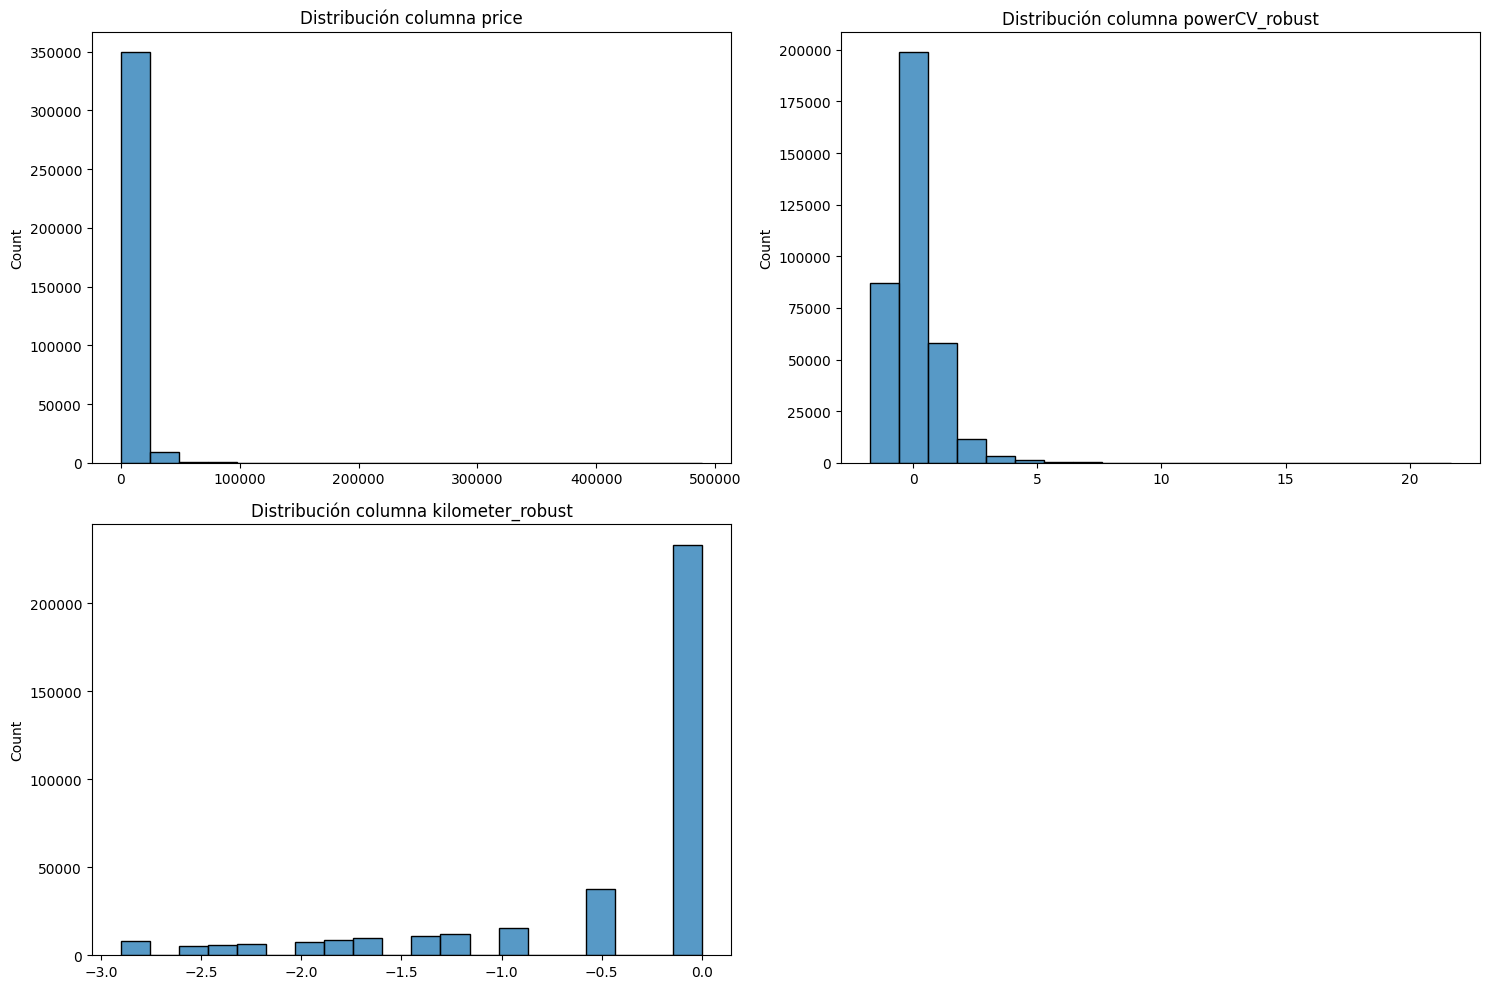

In [5]:
f.plot_outliers_univariados(df_robust, "h", (15,10))

Recuerdo la distribución de las numéricas ya seleccionadas mediante la metodología de escalador robusto

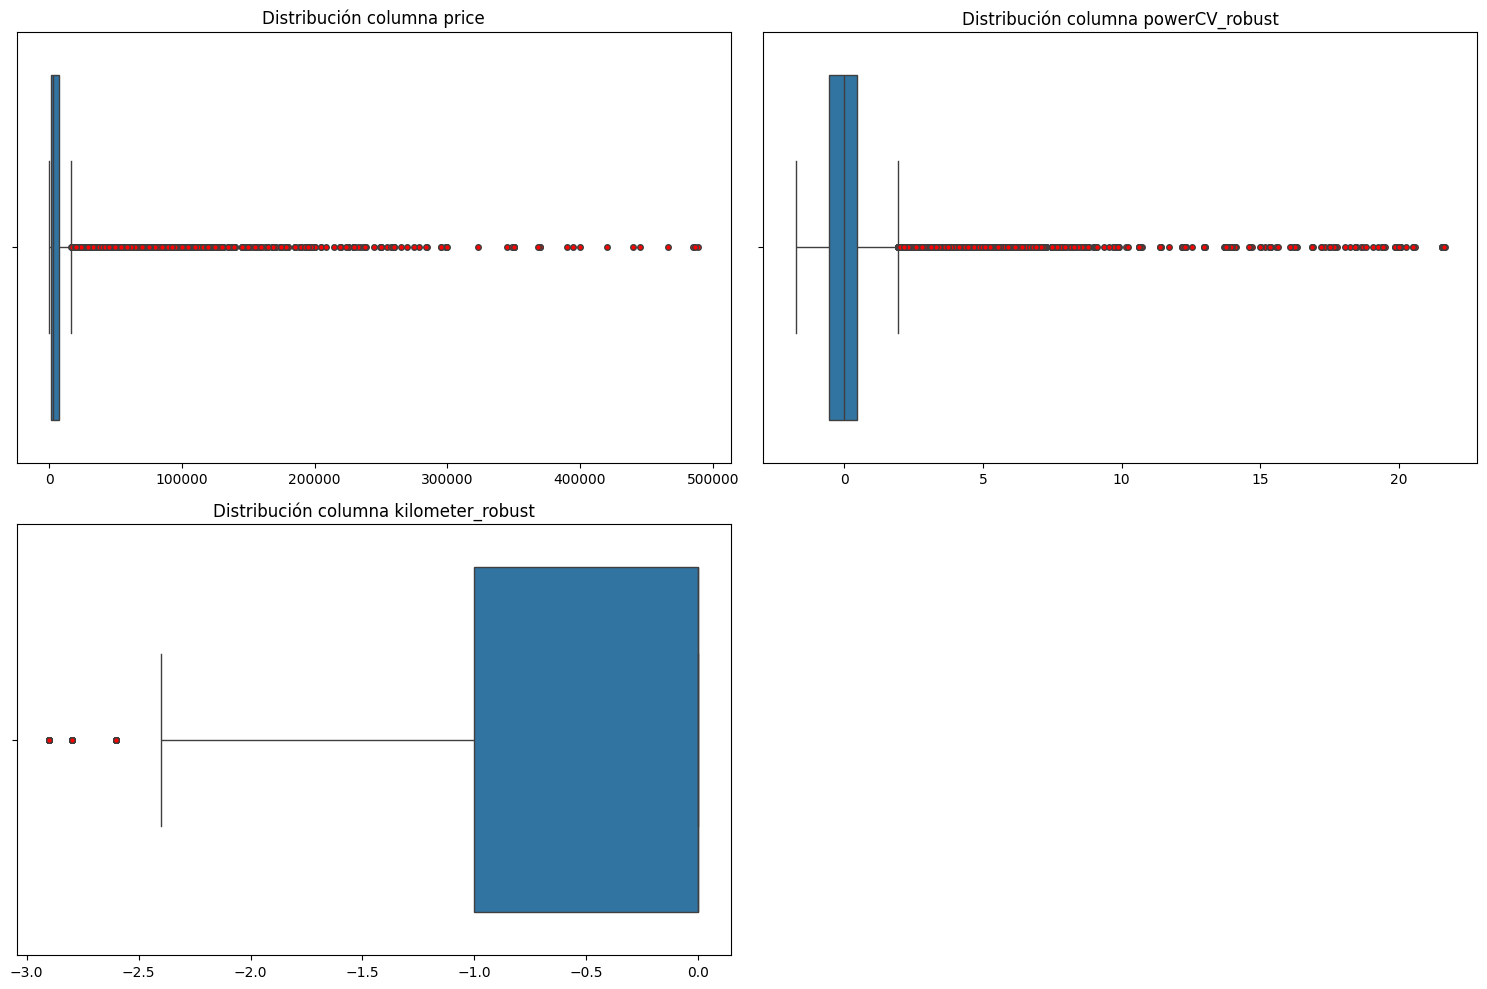

In [6]:
f.plot_outliers_univariados(df_robust, "b", (15,10))

Observo los outliers de las numéricas ya seleccionadas mediante la metodología de escalador robusto

In [7]:
num=df_robust.select_dtypes(include=np.number)
num.describe().T

count         mean          std       min          25%  \
price             360644.0  5913.818220  9220.265780  1.000000  1250.000000   
powerCV_robust    360644.0     0.076874     0.976544 -1.746032    -0.555556   
kilometer_robust  360644.0    -0.486559     0.796447 -2.900000    -1.000000   

                     50%          75%            max  
price             3000.0  7490.000000  488997.000000  
powerCV_robust       0.0     0.444444      21.666667  
kilometer_robust     0.0     0.000000       0.000000

In [8]:
dicc_zsc=f.identificar_outliers_zscore(df_robust)

La cantidad de outliers para la PRICE es de 4512 outliers
La cantidad de outliers para la POWERCV_ROBUST es de 4940 outliers
La cantidad de outliers para la KILOMETER_ROBUST es de 6017 outliers


Dado que no tienen una distribución normal ninguna de ellas, no utilizaré el Z-Score ya que el porcentaje de fallo será demasiado alto. Por ello opto por el IQR

In [9]:
dicc_iqr=f.identificar_outliers_iqr(df_robust)

La columna PRICE tiene 26193 outliers
La columna POWERCV_ROBUST tiene 13194 outliers
La columna KILOMETER_ROBUST tiene 13419 outliers


In [10]:
dicc_iqr["price"].head(2)

dateCrawled   seller offerType  price   abtest vehicleType  \
1   2016-03-24 10:58:45  private     offer  18300     test       coupe   
13  2016-03-21 12:57:01  private     offer  17999  control         suv   

   yearOfRegistration   gearbox        model monthOfRegistration fuelType  \
1              actual  manually  desconocido                   5   diesel   
13             actual  manually       navara                   3   diesel   

     brand notRepairedDamage             lastSeen yearCreated monthCreated  \
1     audi               yes  2016-04-07 01:46:50        2016            3   
13  nissan                no  2016-04-06 07:45:42        2016            3   

    powerCV_robust  kilometer_robust  
1         1.063492              -0.5  
13        1.063492              -1.6

In [11]:
dicc_iqr["powerCV_robust"].head(2)

dateCrawled   seller offerType  price   abtest vehicleType  \
39  2016-03-30 20:38:20  private     offer   7500  control       other   
54  2016-03-21 01:59:07  private     offer  39600     test       coupe   

   yearOfRegistration    gearbox     model monthOfRegistration fuelType  \
39            moderno  automatic  e_klasse                   4    other   
54             actual  automatic    andere                   7   petrol   

            brand notRepairedDamage             lastSeen yearCreated  \
39  mercedes_benz       desconocido  2016-04-03 11:44:49        2016   
54            bmw                no  2016-04-03 23:16:31        2016   

   monthCreated  powerCV_robust  kilometer_robust  
39            3        2.888889               0.0  
54            3        2.888889              -2.4

In [12]:
dicc_iqr["kilometer_robust"].head(2)

dateCrawled   seller offerType  price abtest vehicleType  \
14  2016-03-11 21:39:15  private     offer    450   test   small car   
27  2016-03-09 11:56:38  private     offer   1990   test         bus   

   yearOfRegistration      gearbox        model monthOfRegistration fuelType  \
14            clasico  desconocido           ka         desconocido   petrol   
27              retro     manually  transporter                   1   petrol   

         brand notRepairedDamage             lastSeen yearCreated  \
14        ford       desconocido  2016-03-19 08:46:47        2016   
27  volkswagen                no  2016-03-10 07:44:33        2016   

   monthCreated  powerCV_robust  kilometer_robust  
14            3        0.076874              -2.9  
27            3       -1.126984              -2.9

Observamos como el número de outliers es muy elevado por lo general y no parecen estar muy separados entre ellos. Esto me lleva a pensar que un LOF podría ser la mejor opción. Sin embargo, vamos a comprobarlo. 

In [13]:
contaminacion= [0.01, 0.05, 0.1]
estimadores = [100,400,1000, 2000] 
combinaciones= list(product(contaminacion, estimadores))
for cont, esti in combinaciones:
    
    ifo=IsolationForest(random_state=42, n_estimators=esti, contamination= cont, n_jobs=-1)         #n_estimator es el número de árboles y n_jobs con -1 coge todos los nucleos del ordenador

    df_robust[f"outliers_ifo_{cont}_{esti}"]=ifo.fit_predict(df_robust[["price","powerCV_robust","kilometer_robust"]]) 

In [14]:
df_robust["outliers_ifo_0.01_100"].value_counts(normalize=True)    #Esto nos muetsra como se acerca mucho al 1% de outliers por el nivel de contaminación ser 0.01

outliers_ifo_0.01_100
 1    0.989998
-1    0.010002
Name: proportion, dtype: float64

In [15]:
df_robust.head()

dateCrawled   seller offerType  price abtest vehicleType  \
0  2016-03-24 11:52:17  private     offer    480   test       other   
1  2016-03-24 10:58:45  private     offer  18300   test       coupe   
2  2016-03-14 12:52:21  private     offer   9800   test         suv   
3  2016-03-17 16:54:04  private     offer   1500   test   small car   
4  2016-03-31 17:25:20  private     offer   3600   test   small car   

  yearOfRegistration    gearbox        model monthOfRegistration  ...  \
0            moderno   manually         golf         desconocido  ...   
1             actual   manually  desconocido                   5  ...   
2            moderno  automatic        grand                   8  ...   
3            moderno   manually         golf                   6  ...   
4            moderno   manually        fabia                   7  ...   

  outliers_ifo_0.01_1000 outliers_ifo_0.01_2000 outliers_ifo_0.05_100  \
0                      1                      1                     1   
1                      1                      1                     1   
2                      1                      1                     1   
3                      1                      1                     1   
4                      1                      1                     1   

  outliers_ifo_0.05_400 outliers_ifo_0.05_1000 outliers_ifo_0.05_2000  \
0                     1                      1                      1   
1                     1                      1                      1   
2                     1                      1                      1   
3                     1                      1                      1   
4                     1                      1                      1   

   outliers_ifo_0.1_100  outliers_ifo_0.1_400  outliers_ifo_0.1_1000  \
0                     1                     1                      1   
1                    -1                     1                      1   
2                     1                     1                      1   
3                     1                     1                      1   
4                     1                     1                      1   

   outliers_ifo_0.1_2000  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  

[5 rows x 30 columns]

In [16]:
columnas_hue=df_robust.filter(like="outliers")

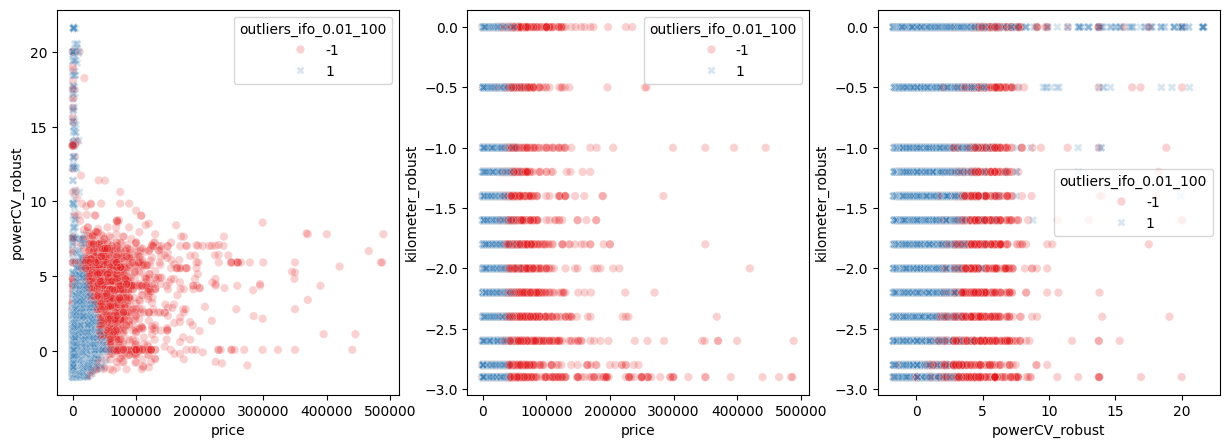

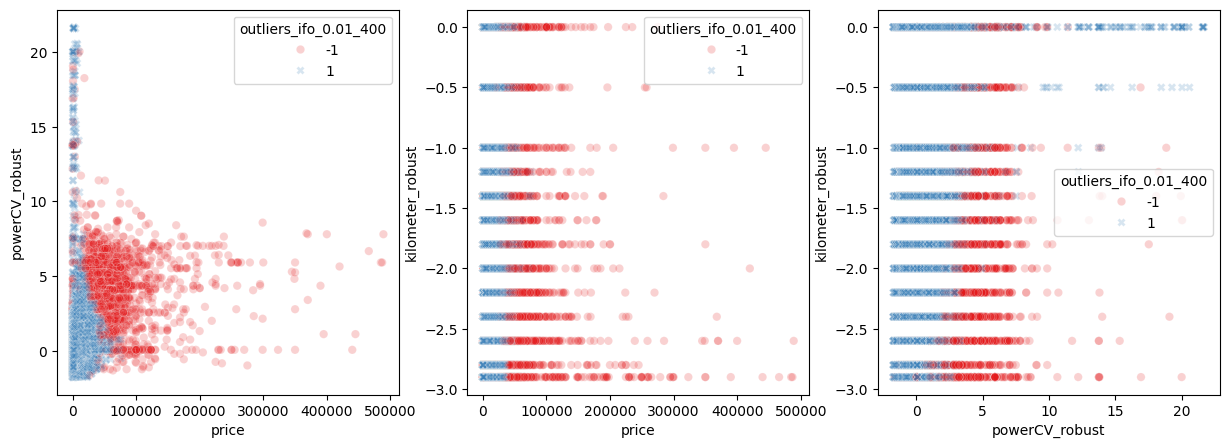

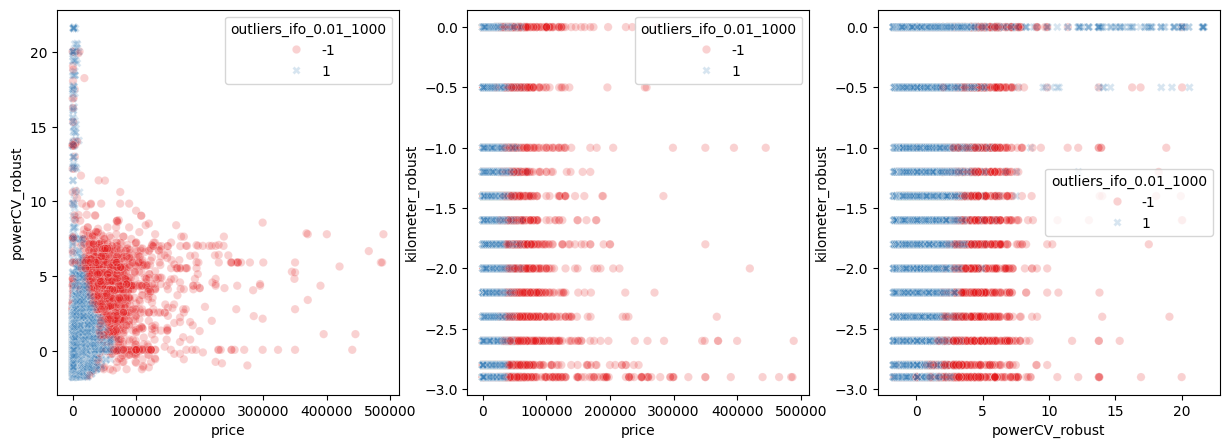

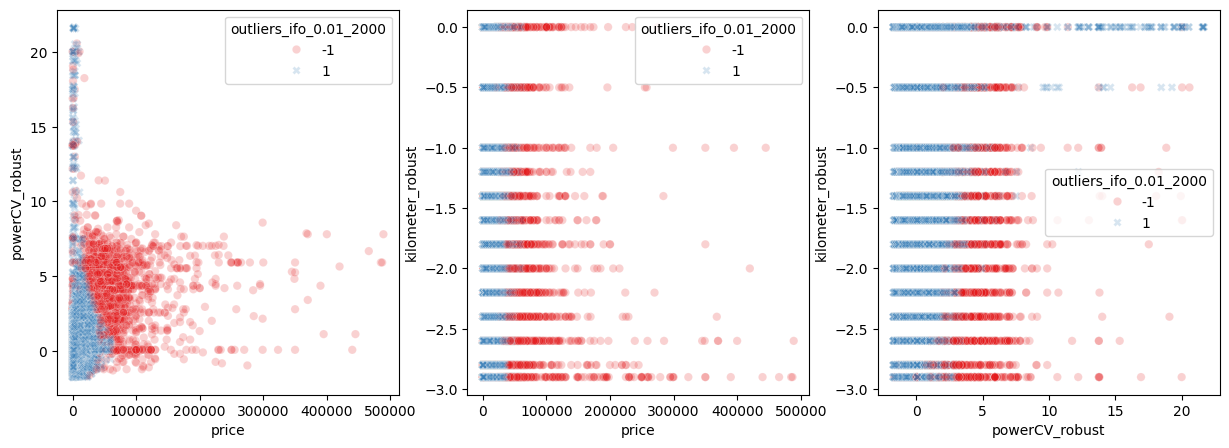

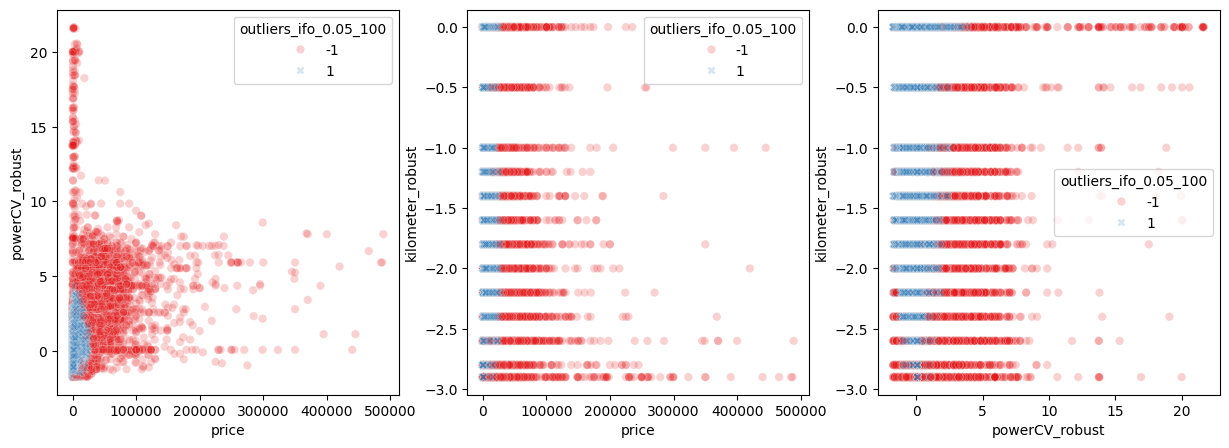

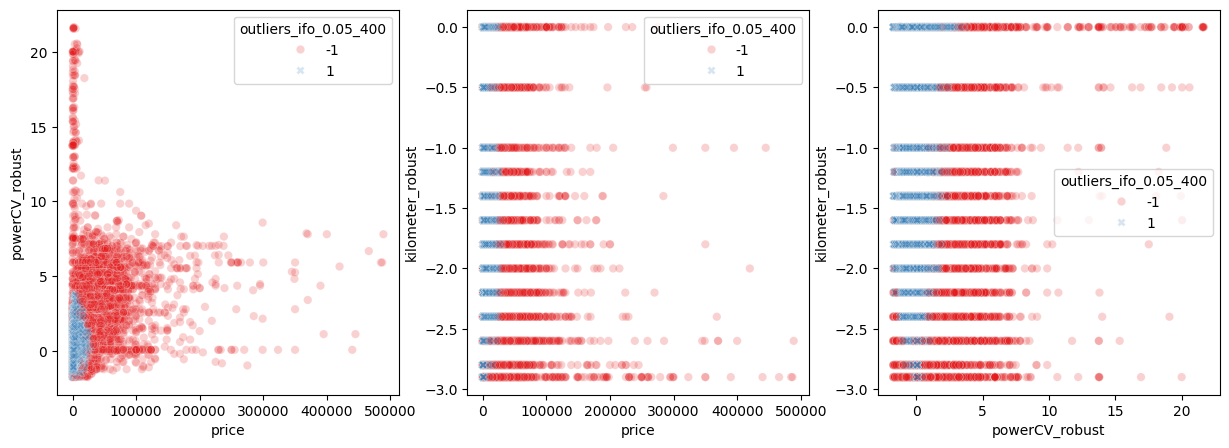

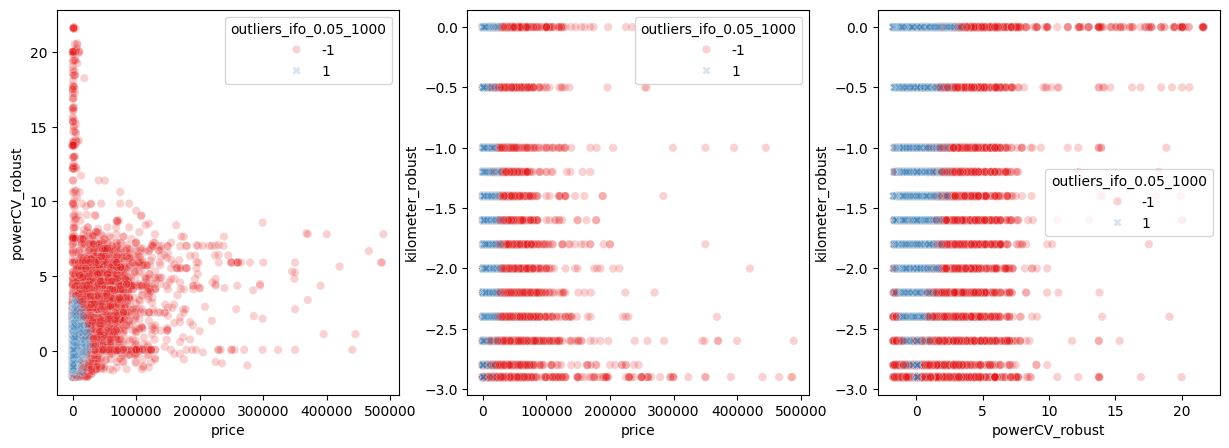

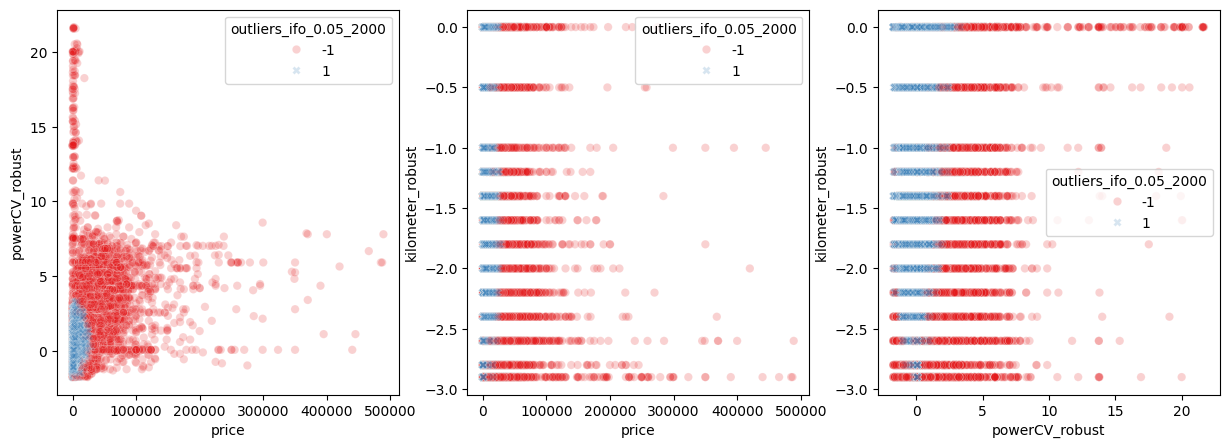

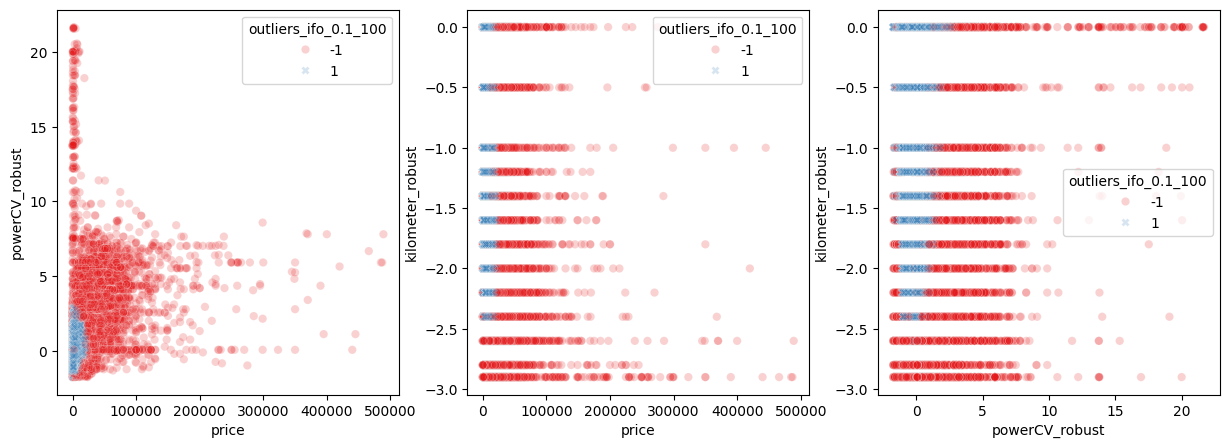

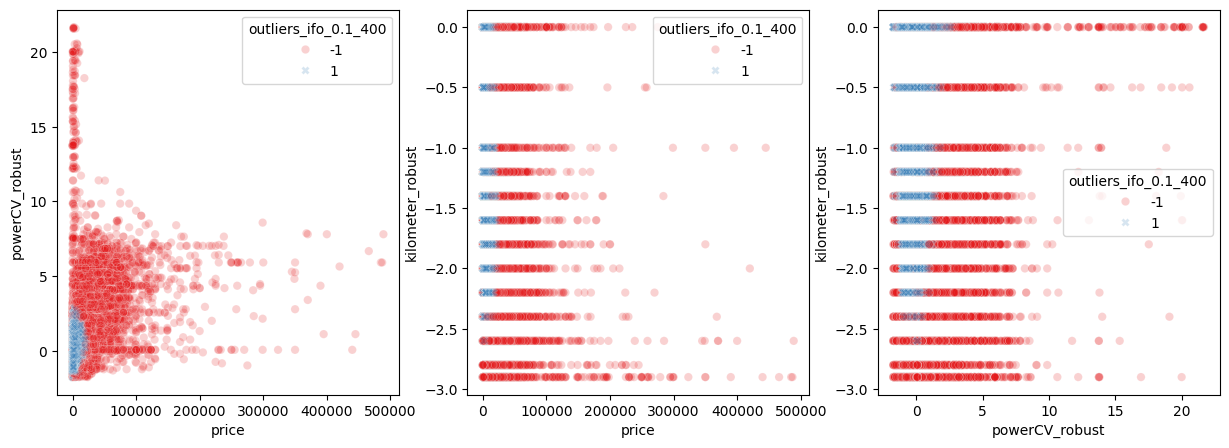

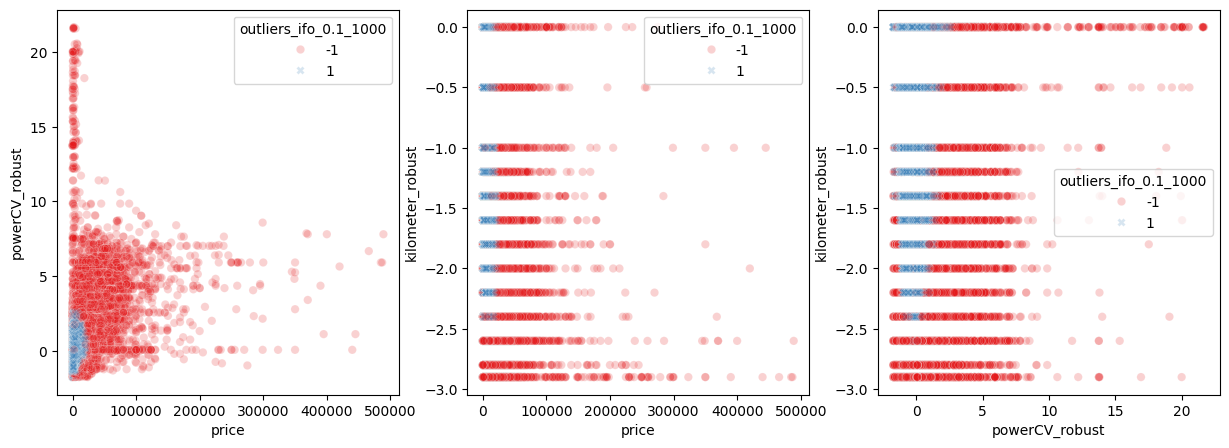

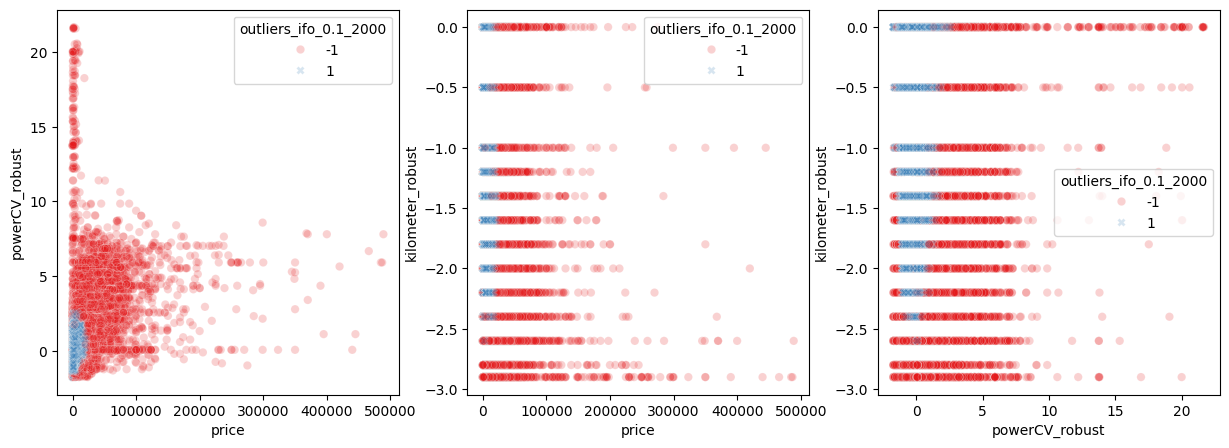

In [17]:
combinaciones_visual=list(combinations(["price","powerCV_robust","kilometer_robust"], 2))

for out in columnas_hue:


    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(15,5))
    axes=axes.flat
    for indice, tupla in enumerate(combinaciones_visual):
        sns.scatterplot(x=tupla[0], y=tupla[1], ax= axes[indice], data=df_robust, hue= out, palette= "Set1", alpha= 0.2, style= out)

Observamos como a mayor número de arboles los outliers se van agrupando más.  
Además según vamos siendo más estrictos con el nivel de contaminación, más sentido tiene la interpretación. 
Un ejemplo de esto es la conclusión del scaterplot entre los kilometros y la potencia. En este ejemplo se puede ver como los valores no outliers son a partir de lo que corresponde a unos 40.000km (además vamos viendo como van aumentando el número de vehículos según vamos yendo a kilometrajes más altos) y en el caso de la potencia se concentran entre las potencias bajas y los 180 caballos de potencia aproximadamente.  
  
Por otra parte, en los otros dos scatterplots, observamos como en el caso del precio los datos no outliers se encuentran entre 0 y los 23.000 € aproximadamente.

In [18]:
df_robust.head()

dateCrawled   seller offerType  price abtest vehicleType  \
0  2016-03-24 11:52:17  private     offer    480   test       other   
1  2016-03-24 10:58:45  private     offer  18300   test       coupe   
2  2016-03-14 12:52:21  private     offer   9800   test         suv   
3  2016-03-17 16:54:04  private     offer   1500   test   small car   
4  2016-03-31 17:25:20  private     offer   3600   test   small car   

  yearOfRegistration    gearbox        model monthOfRegistration  ...  \
0            moderno   manually         golf         desconocido  ...   
1             actual   manually  desconocido                   5  ...   
2            moderno  automatic        grand                   8  ...   
3            moderno   manually         golf                   6  ...   
4            moderno   manually        fabia                   7  ...   

  outliers_ifo_0.01_1000 outliers_ifo_0.01_2000 outliers_ifo_0.05_100  \
0                      1                      1                     1   
1                      1                      1                     1   
2                      1                      1                     1   
3                      1                      1                     1   
4                      1                      1                     1   

  outliers_ifo_0.05_400 outliers_ifo_0.05_1000 outliers_ifo_0.05_2000  \
0                     1                      1                      1   
1                     1                      1                      1   
2                     1                      1                      1   
3                     1                      1                      1   
4                     1                      1                      1   

   outliers_ifo_0.1_100  outliers_ifo_0.1_400  outliers_ifo_0.1_1000  \
0                     1                     1                      1   
1                    -1                     1                      1   
2                     1                     1                      1   
3                     1                     1                      1   
4                     1                     1                      1   

   outliers_ifo_0.1_2000  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  

[5 rows x 30 columns]

A pesar de que las gráficas tienen sentido debido a la dispersión y cantidad de los datos es más correcto un LOF voy a sacarlos juntos para que se observe la diferencia en los scatter plots entre IFO y LOF

100%|██████████| 21/21 [01:37<00:00,  4.63s/it]


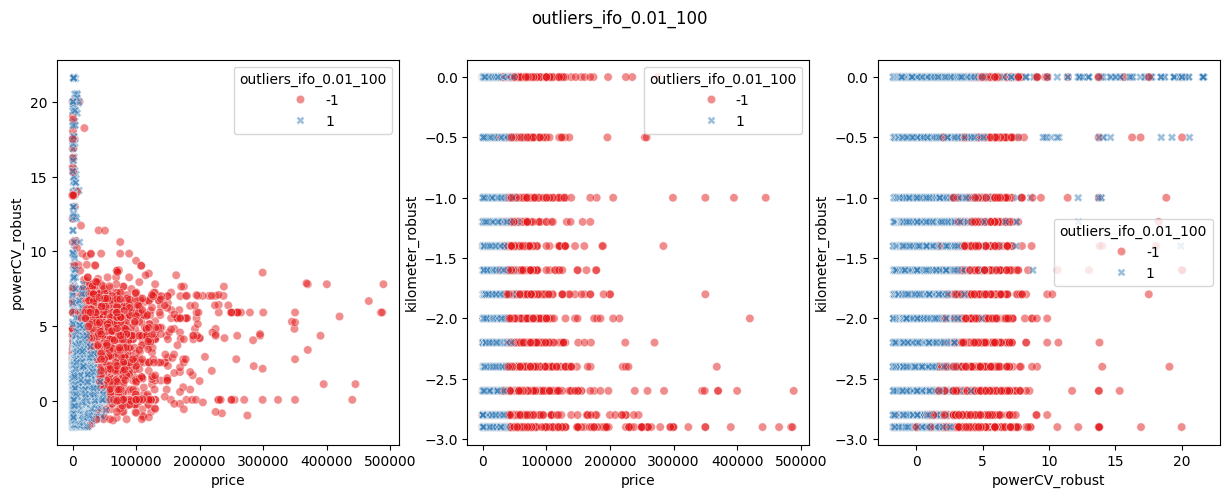

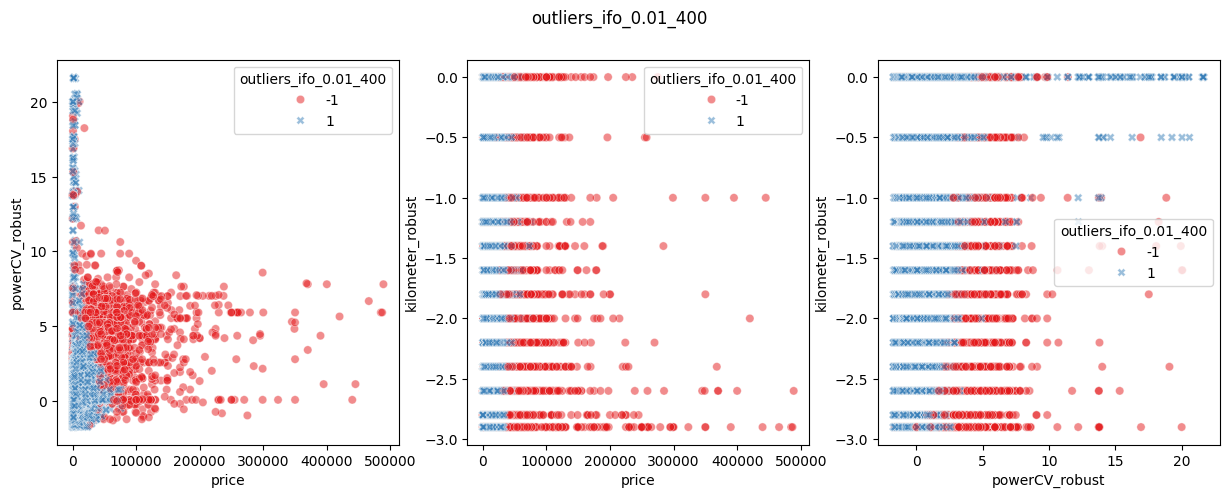

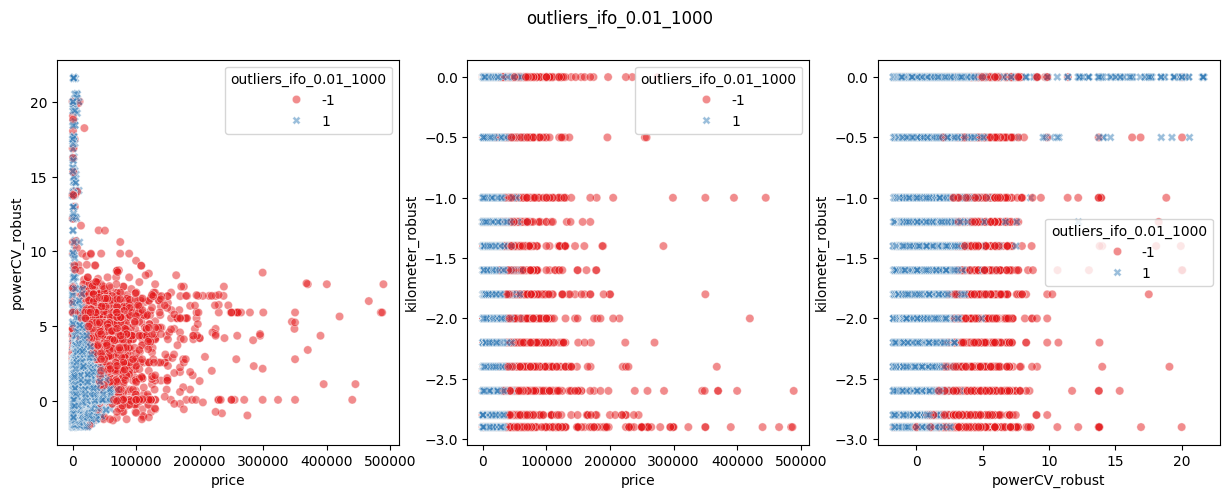

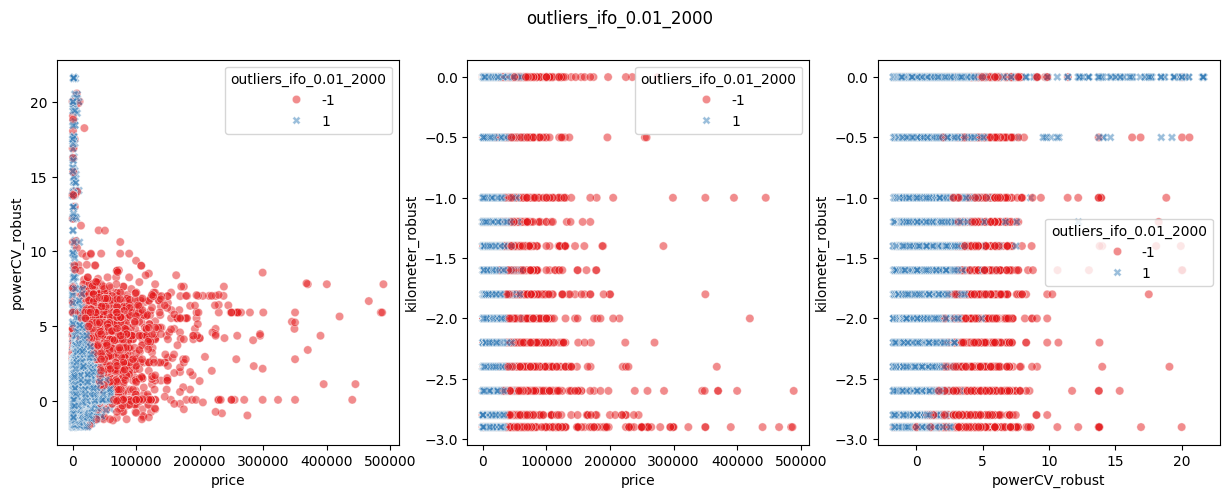

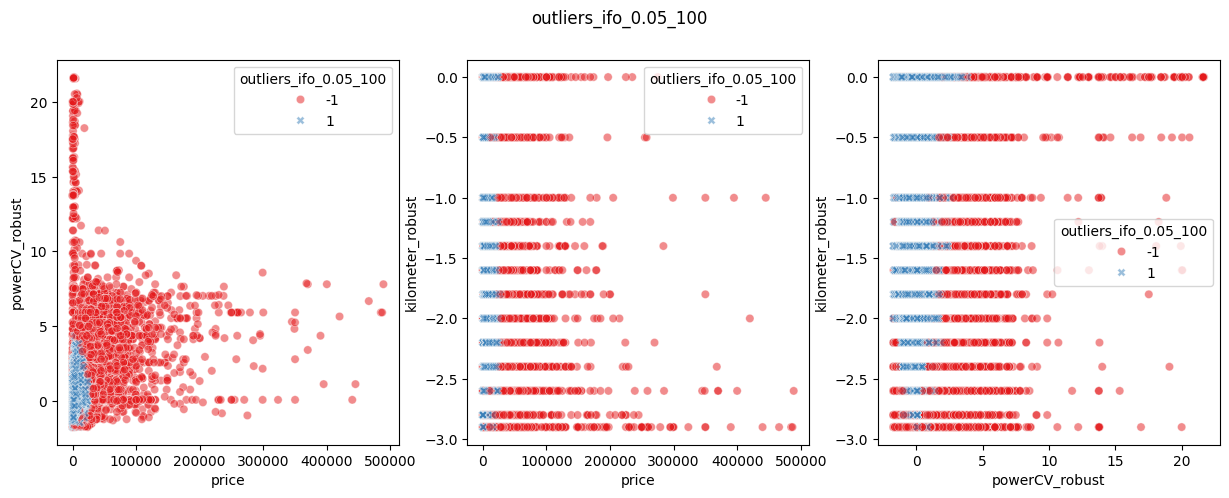

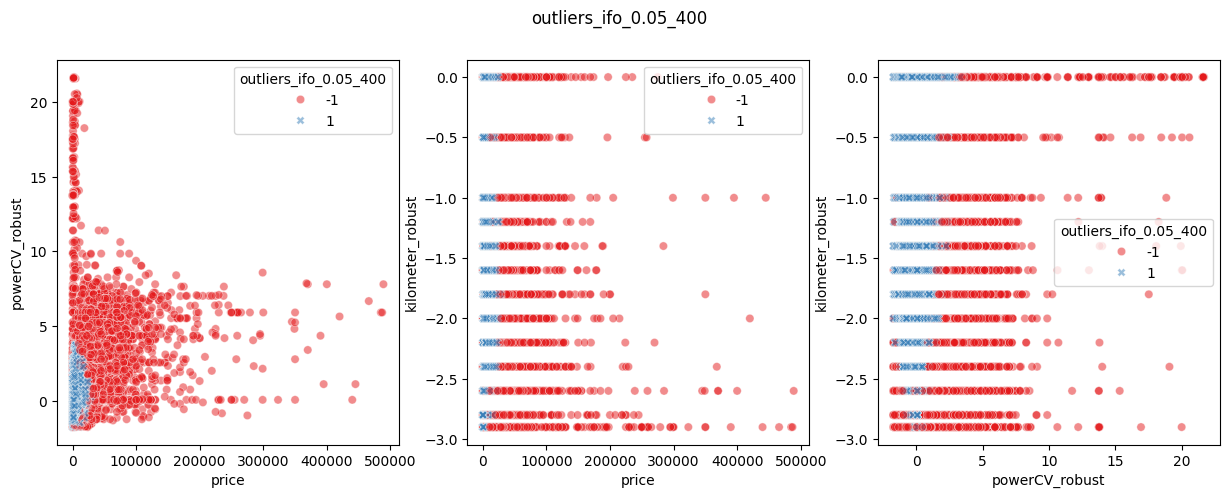

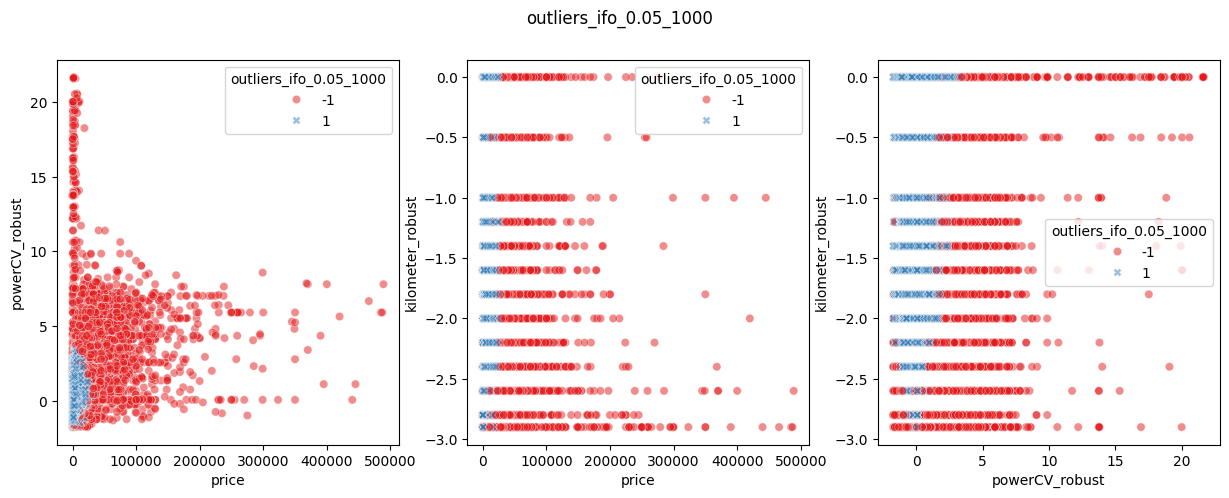

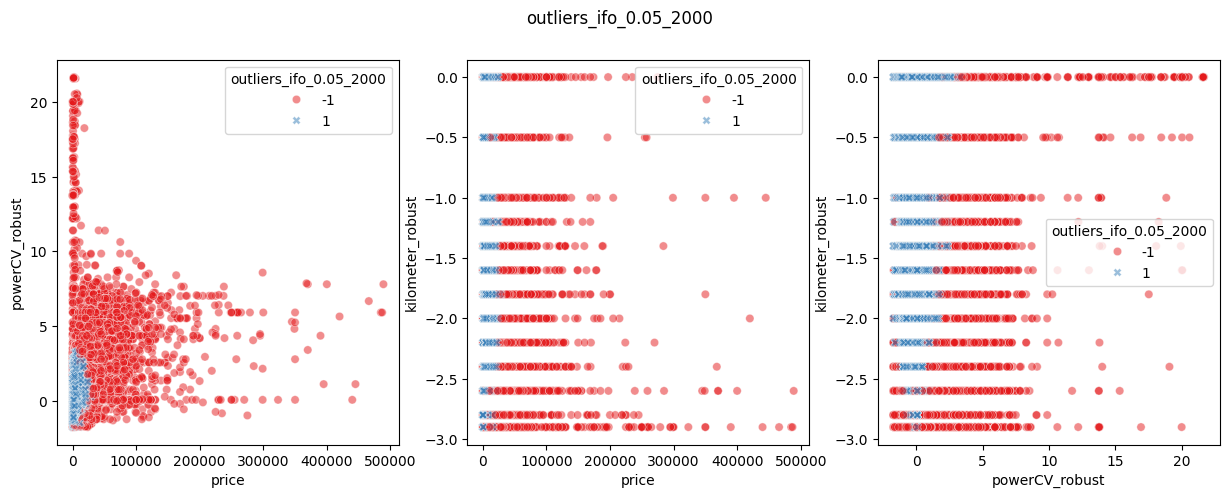

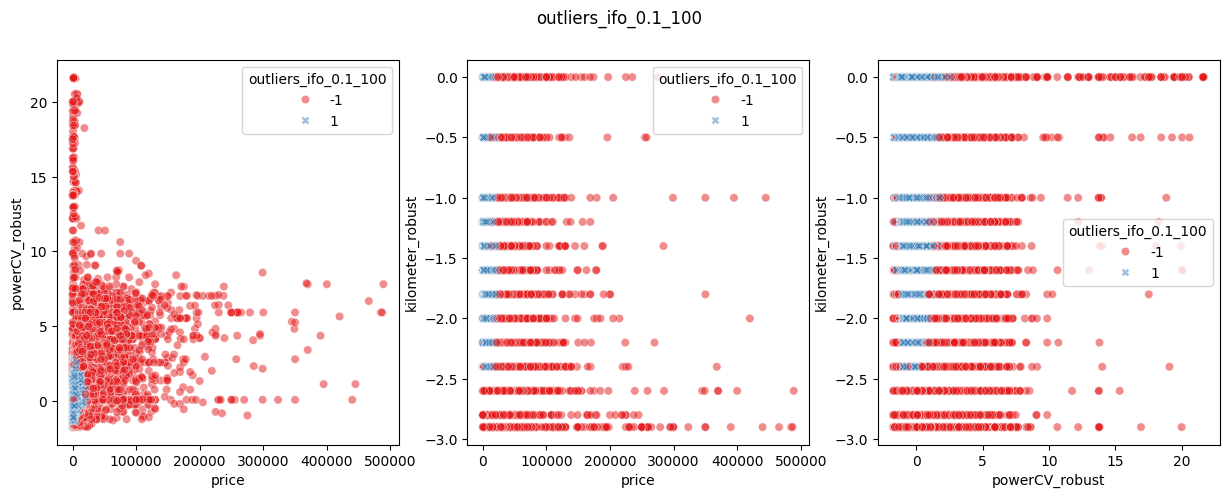

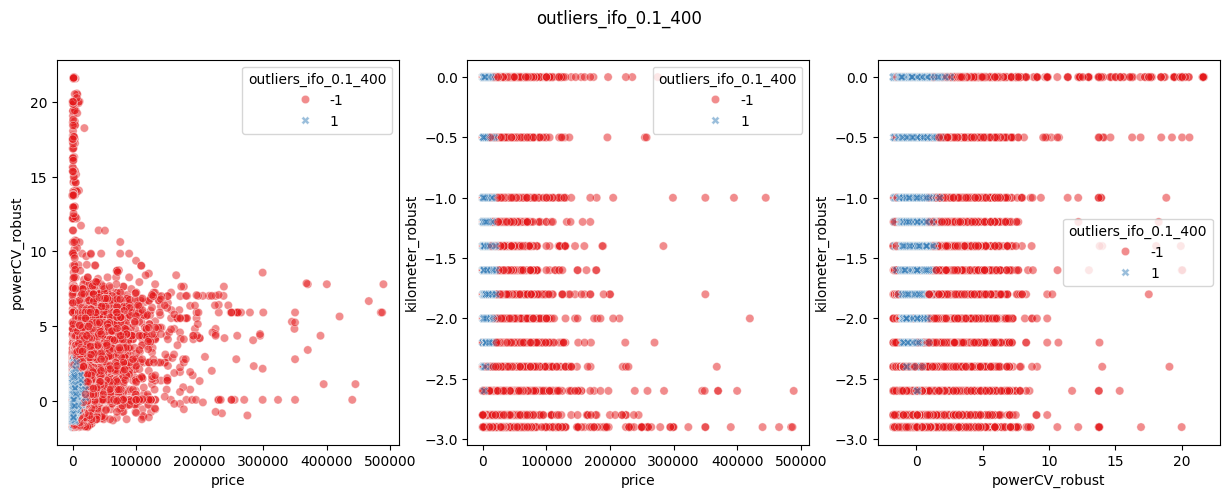

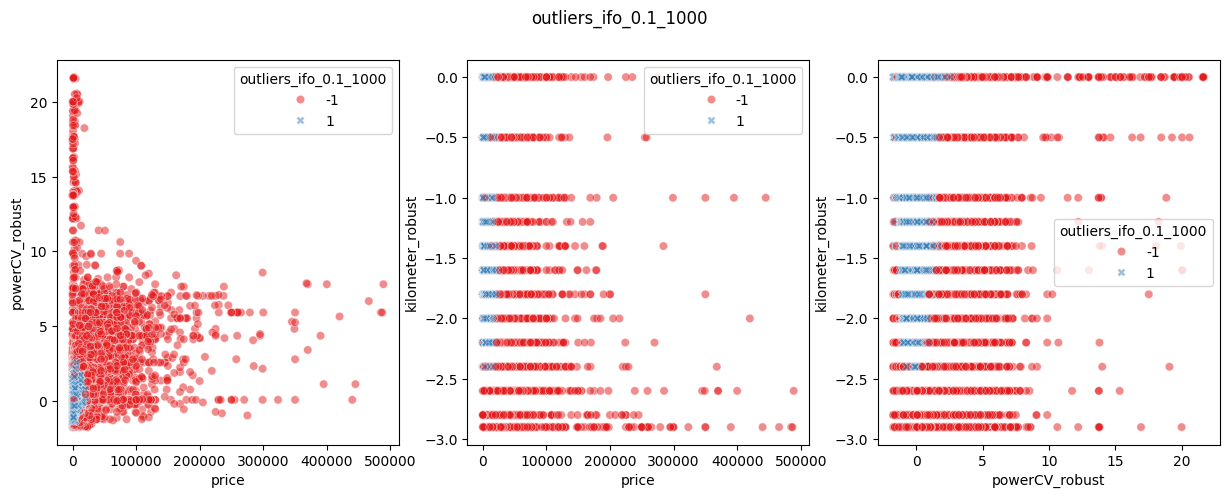

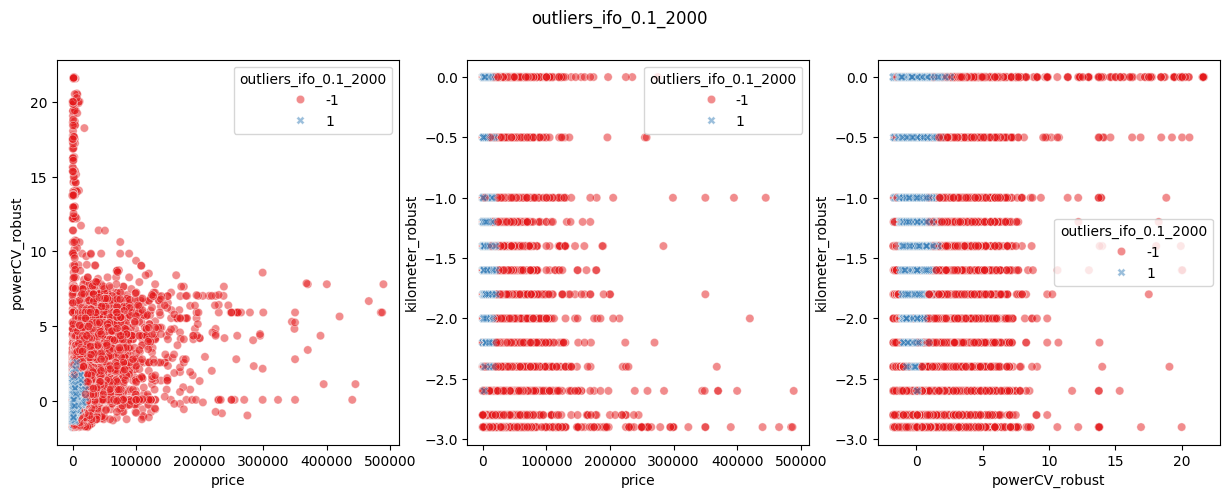

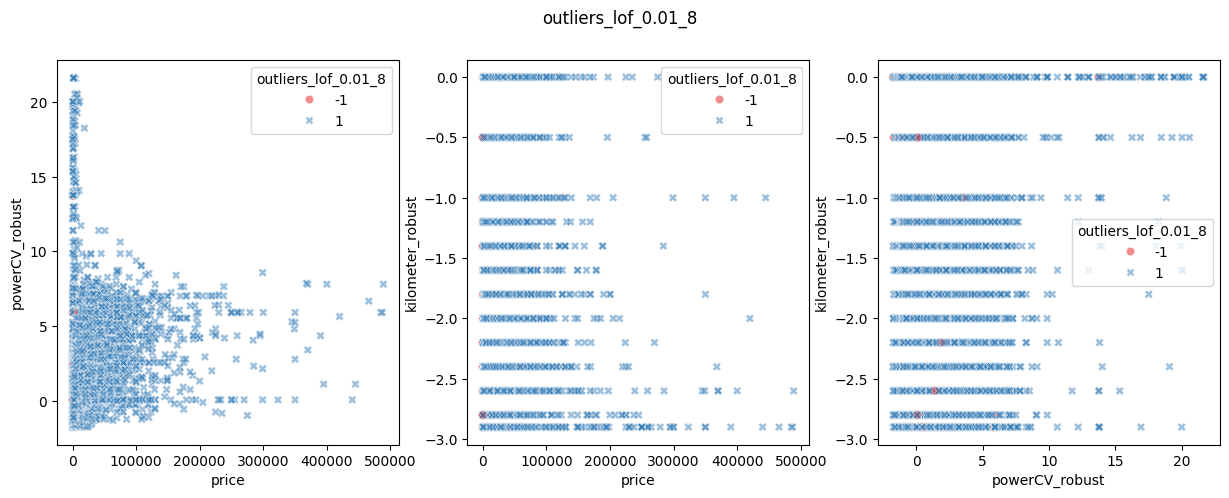

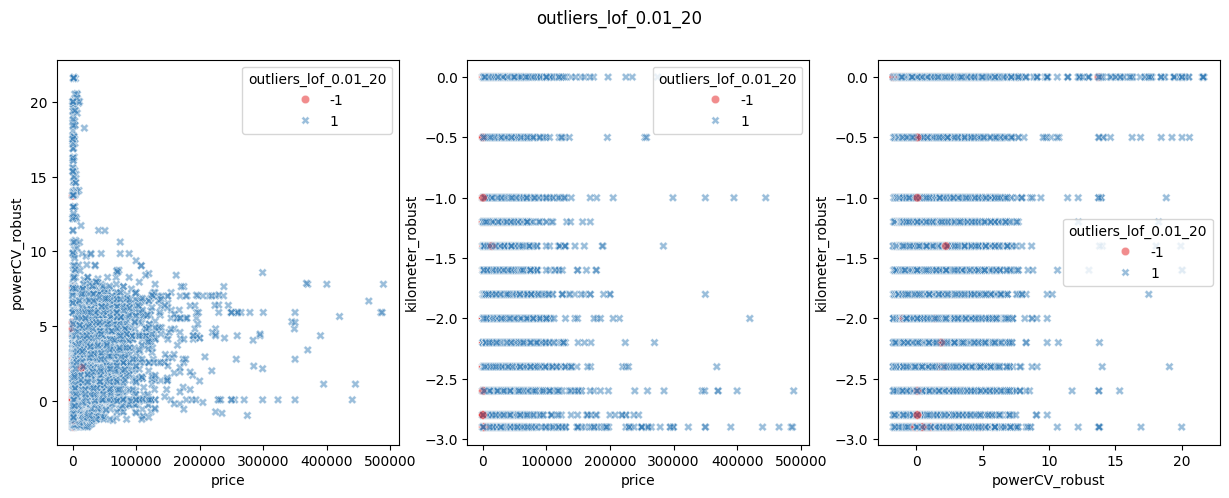

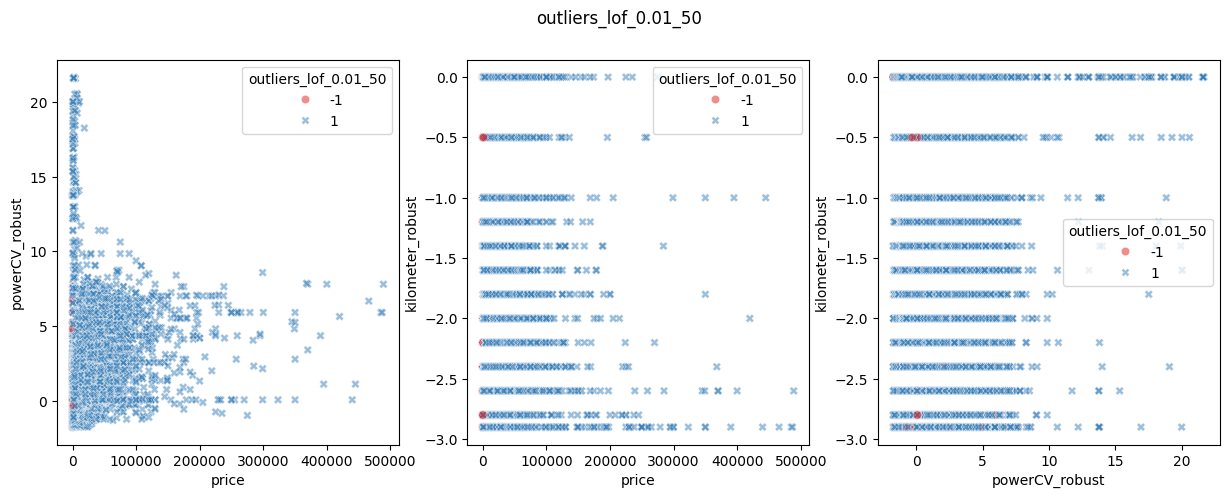

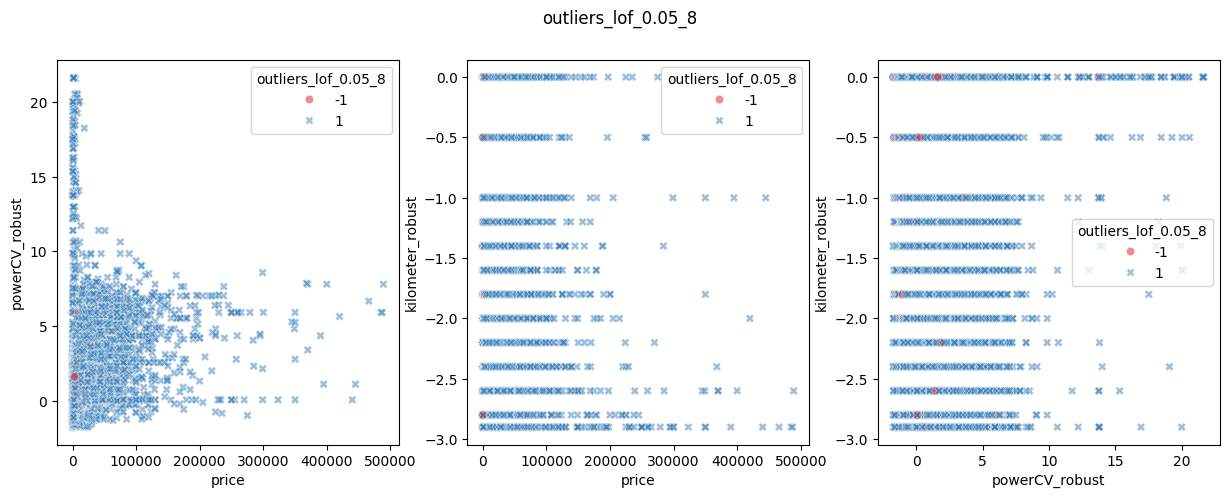

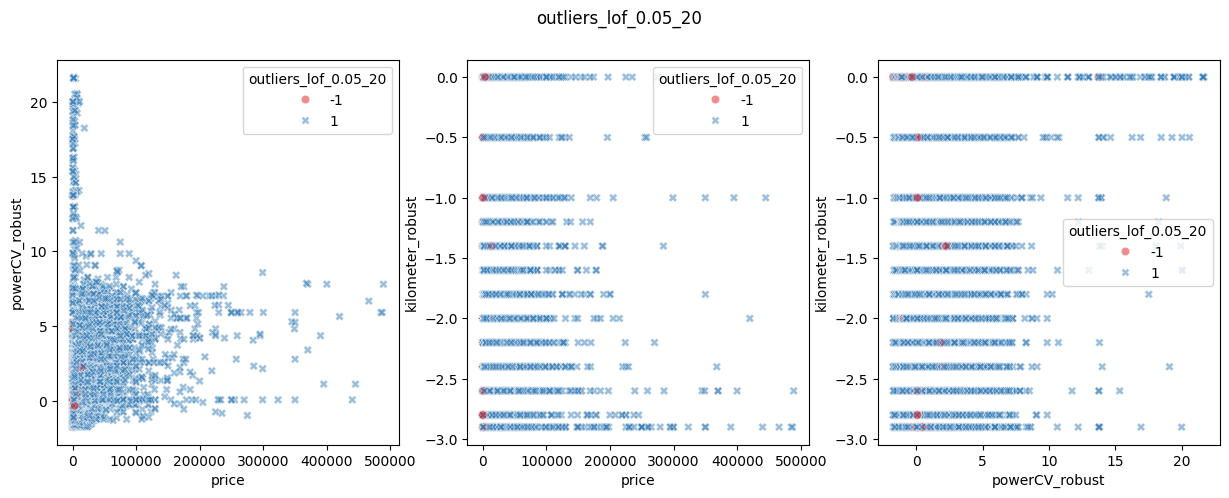

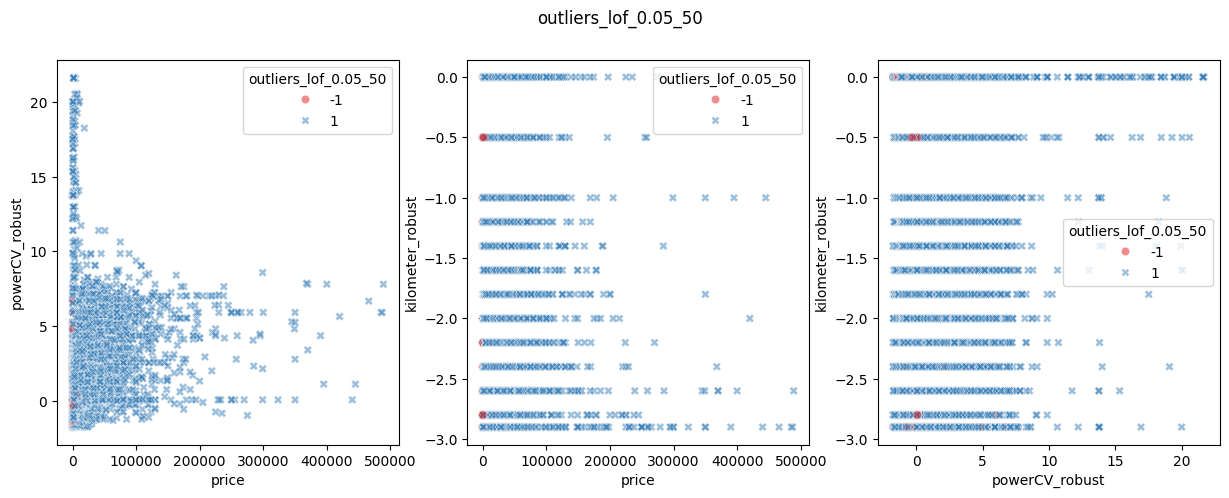

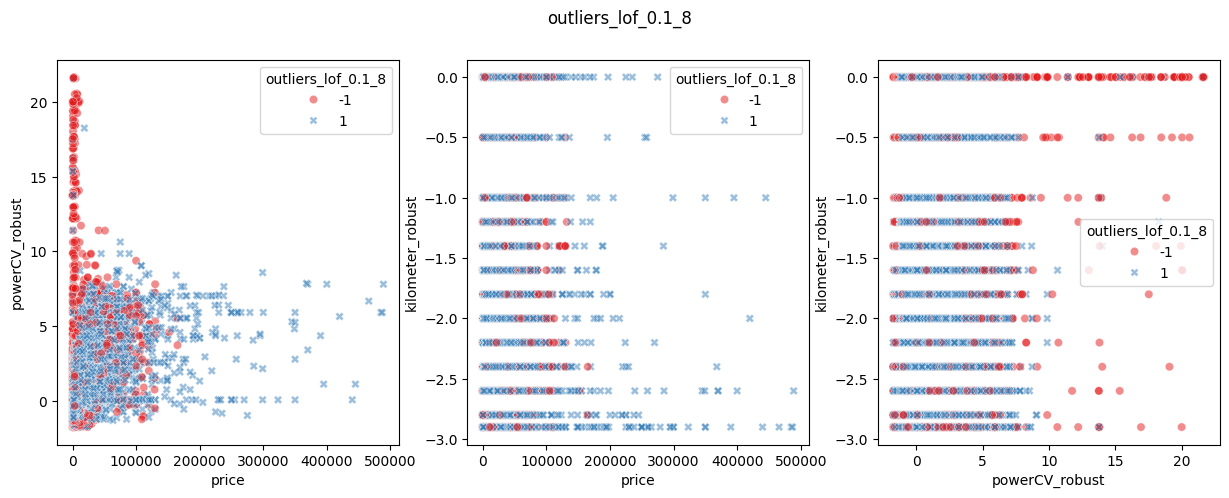

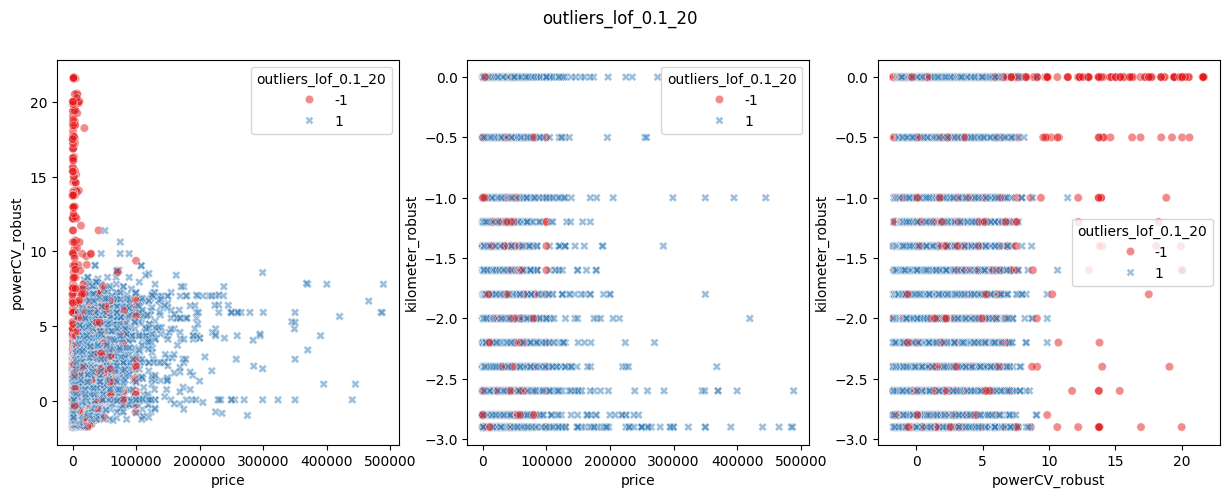

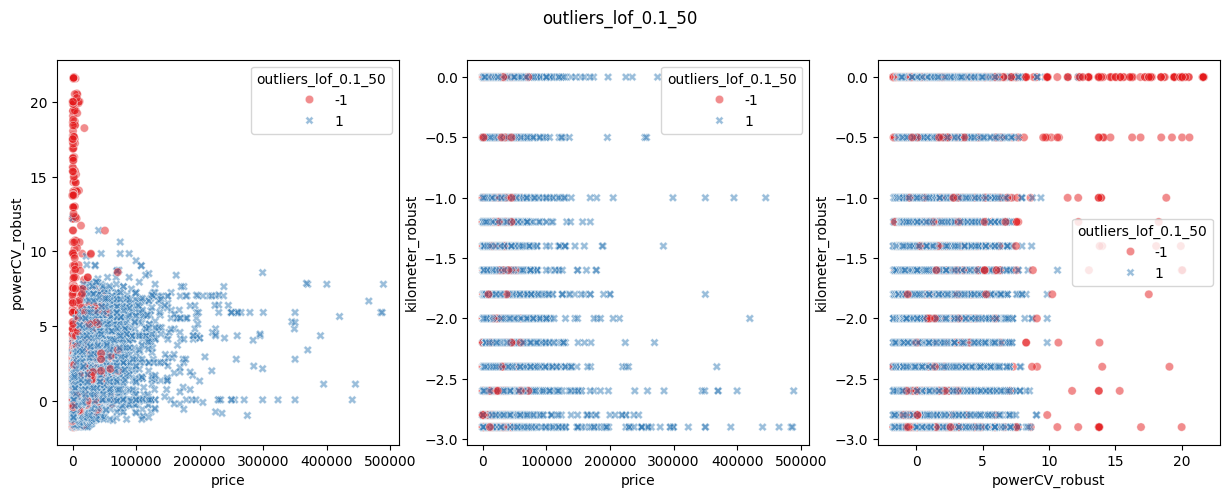

In [19]:
lista_contaminaciones = [0.01, 0.05, 0.1]
lista_neighbors = [8,20, 50]

combinaciones = list(product(lista_contaminaciones, lista_neighbors))
combinaciones


for cont, neighbors in tqdm(combinaciones):
    lof = LocalOutlierFactor(n_neighbors=neighbors,
                            contamination=cont,
                            n_jobs=-1)

    df_robust[f"outliers_lof_{cont}_{neighbors}"] = lof.fit_predict(df_robust[["price", "powerCV_robust", "kilometer_robust"]])
    y_pred = lof.fit_predict(df_robust[["price", "powerCV_robust", "kilometer_robust"]])
df_robust

#visualizacion
columnas_hue = df_robust.filter(like="outlier").columns

combinaciones_viz = list(combinations(["price", "powerCV_robust", "kilometer_robust"], 2))
combinaciones_viz

for outlier in tqdm(columnas_hue):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15, 5))
    axes = axes.flat

    for indice, tupla in enumerate(combinaciones_viz):
        sns.scatterplot(x = tupla[0],
                        y = tupla[1],
                        ax = axes[indice],
                        data = df_robust,
                        hue=outlier,
                        palette="Set1",
                        style=outlier,
                        alpha=0.5)
        
    plt.suptitle(outlier)

Lo que saco en claro es que el nivel de contaminación más estricto (10%) es la mejor opción porque es el que más se acerca a la realidad de los datos.  
En cuanto al número de vecinos, me gustaría coger menos vecinos a 20 (que es el que más parece reflejar la realidad) por ejemplo 8.  


In [20]:
df_robust.head()

dateCrawled   seller offerType  price abtest vehicleType  \
0  2016-03-24 11:52:17  private     offer    480   test       other   
1  2016-03-24 10:58:45  private     offer  18300   test       coupe   
2  2016-03-14 12:52:21  private     offer   9800   test         suv   
3  2016-03-17 16:54:04  private     offer   1500   test   small car   
4  2016-03-31 17:25:20  private     offer   3600   test   small car   

  yearOfRegistration    gearbox        model monthOfRegistration  ...  \
0            moderno   manually         golf         desconocido  ...   
1             actual   manually  desconocido                   5  ...   
2            moderno  automatic        grand                   8  ...   
3            moderno   manually         golf                   6  ...   
4            moderno   manually        fabia                   7  ...   

  outliers_ifo_0.1_2000 outliers_lof_0.01_8 outliers_lof_0.01_20  \
0                     1                   1                    1   
1                     1                   1                    1   
2                     1                   1                    1   
3                     1                   1                    1   
4                     1                   1                    1   

  outliers_lof_0.01_50 outliers_lof_0.05_8 outliers_lof_0.05_20  \
0                    1                   1                    1   
1                    1                   1                    1   
2                    1                   1                    1   
3                    1                   1                    1   
4                    1                   1                    1   

   outliers_lof_0.05_50  outliers_lof_0.1_8  outliers_lof_0.1_20  \
0                     1                   1                    1   
1                     1                   1                    1   
2                     1                   1                    1   
3                     1                   1                    1   
4                     1                   1                    1   

   outliers_lof_0.1_50  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1  

[5 rows x 39 columns]

In [21]:
df_robust.columns

Index(['dateCrawled', 'seller', 'offerType', 'price', 'abtest', 'vehicleType',
       'yearOfRegistration', 'gearbox', 'model', 'monthOfRegistration',
       'fuelType', 'brand', 'notRepairedDamage', 'lastSeen', 'yearCreated',
       'monthCreated', 'powerCV_robust', 'kilometer_robust',
       'outliers_ifo_0.01_100', 'outliers_ifo_0.01_400',
       'outliers_ifo_0.01_1000', 'outliers_ifo_0.01_2000',
       'outliers_ifo_0.05_100', 'outliers_ifo_0.05_400',
       'outliers_ifo_0.05_1000', 'outliers_ifo_0.05_2000',
       'outliers_ifo_0.1_100', 'outliers_ifo_0.1_400', 'outliers_ifo_0.1_1000',
       'outliers_ifo_0.1_2000', 'outliers_lof_0.01_8', 'outliers_lof_0.01_20',
       'outliers_lof_0.01_50', 'outliers_lof_0.05_8', 'outliers_lof_0.05_20',
       'outliers_lof_0.05_50', 'outliers_lof_0.1_8', 'outliers_lof_0.1_20',
       'outliers_lof_0.1_50'],
      dtype='object')

In [22]:
df_lof=df_robust[['dateCrawled', 'seller', 'offerType', 'price', 'abtest', 'vehicleType',
       'yearOfRegistration', 'gearbox', 'model', 'monthOfRegistration',
       'fuelType', 'brand', 'notRepairedDamage', 'lastSeen', 'yearCreated',
       'monthCreated', 'powerCV_robust', 'kilometer_robust', 'outliers_lof_0.01_20',
       'outliers_lof_0.01_50', 'outliers_lof_0.05_20',
       'outliers_lof_0.05_50', 'outliers_lof_0.1_20',
       'outliers_lof_0.1_50', 'outliers_lof_0.01_8', 'outliers_lof_0.05_8',
       'outliers_lof_0.1_8']]

In [23]:
df_lof.head()

dateCrawled   seller offerType  price abtest vehicleType  \
0  2016-03-24 11:52:17  private     offer    480   test       other   
1  2016-03-24 10:58:45  private     offer  18300   test       coupe   
2  2016-03-14 12:52:21  private     offer   9800   test         suv   
3  2016-03-17 16:54:04  private     offer   1500   test   small car   
4  2016-03-31 17:25:20  private     offer   3600   test   small car   

  yearOfRegistration    gearbox        model monthOfRegistration  ...  \
0            moderno   manually         golf         desconocido  ...   
1             actual   manually  desconocido                   5  ...   
2            moderno  automatic        grand                   8  ...   
3            moderno   manually         golf                   6  ...   
4            moderno   manually        fabia                   7  ...   

  kilometer_robust outliers_lof_0.01_20 outliers_lof_0.01_50  \
0              0.0                    1                    1   
1             -0.5                    1                    1   
2             -0.5                    1                    1   
3              0.0                    1                    1   
4             -1.2                    1                    1   

  outliers_lof_0.05_20 outliers_lof_0.05_50 outliers_lof_0.1_20  \
0                    1                    1                   1   
1                    1                    1                   1   
2                    1                    1                   1   
3                    1                    1                   1   
4                    1                    1                   1   

   outliers_lof_0.1_50  outliers_lof_0.01_8  outliers_lof_0.05_8  \
0                    1                    1                    1   
1                    1                    1                    1   
2                    1                    1                    1   
3                    1                    1                    1   
4                    1                    1                    1   

   outliers_lof_0.1_8  
0                   1  
1                   1  
2                   1  
3                   1  
4                   1  

[5 rows x 27 columns]

Ahora me quito las que tengan todas las filas con 1 y así me quedo con todas las que al menos tienen un Outlier

In [24]:
columnasdf=df_robust.filter(like="outliers_lof")
columnas_lof=columnasdf.columns

In [25]:

filtered_df = df_lof[(df_lof[columnas_lof] == -1).all(axis=1)]

In [26]:
filtered_df.head()

dateCrawled   seller offerType  price   abtest vehicleType  \
311   2016-03-21 14:38:37  private     offer    200  control       other   
1434  2016-03-08 14:58:51  private     offer   2001     test       combi   
1859  2016-03-06 11:47:58  private     offer   3501     test       other   
2033  2016-03-28 21:06:39  private     offer   1001     test   small car   
2690  2016-03-30 21:53:36  private     offer    180     test       other   

     yearOfRegistration      gearbox        model monthOfRegistration  ...  \
311             moderno  desconocido  desconocido         desconocido  ...   
1434            moderno     manually           a4                  10  ...   
1859             actual     manually         golf         desconocido  ...   
2033            moderno     manually         lupo                   1  ...   
2690             actual  desconocido         polo         desconocido  ...   

     kilometer_robust outliers_lof_0.01_20 outliers_lof_0.01_50  \
311              -2.8                   -1                   -1   
1434              0.0                   -1                   -1   
1859              0.0                   -1                   -1   
2033              0.0                   -1                   -1   
2690             -0.5                   -1                   -1   

     outliers_lof_0.05_20 outliers_lof_0.05_50 outliers_lof_0.1_20  \
311                    -1                   -1                  -1   
1434                   -1                   -1                  -1   
1859                   -1                   -1                  -1   
2033                   -1                   -1                  -1   
2690                   -1                   -1                  -1   

      outliers_lof_0.1_50  outliers_lof_0.01_8  outliers_lof_0.05_8  \
311                    -1                   -1                   -1   
1434                   -1                   -1                   -1   
1859                   -1                   -1                   -1   
2033                   -1                   -1                   -1   
2690                   -1                   -1                   -1   

      outliers_lof_0.1_8  
311                   -1  
1434                  -1  
1859                  -1  
2033                  -1  
2690                  -1  

[5 rows x 27 columns]

Como solo suponen un 0,2% del total de filas y todos los modelos los han considerado outliers (Tras haberlos revisado). Se decide eliminarlos

In [27]:
df_result = df_lof.drop(index = filtered_df.index)

In [28]:
df_result.reset_index(drop=True, inplace=True)

In [29]:
df_result.shape

(360401, 27)

In [30]:
proporcion = 0.6 * len(columnas_lof)
df_outliers_60 = df_result[df_result[columnas_lof].eq(-1).sum(axis=1) >= proporcion]


In [31]:
df_lof.shape

(360644, 27)

Observamos la potencia

In [32]:
df_outliers_60["powerCV_robust"].shape

(2872,)

In [33]:
df_outliers_60[df_outliers_60["powerCV_robust"] < 0]["powerCV_robust"].min

<bound method Series.min of 117      -0.698413
327      -0.698413
827      -0.095238
979      -1.063492
1892     -0.158730
            ...   
358790   -0.206349
358926   -0.968254
359469   -0.111111
359757   -0.968254
360063   -0.746032
Name: powerCV_robust, Length: 1268, dtype: float64>

In [34]:
df_outliers_60[df_outliers_60["powerCV_robust"] < 0]["powerCV_robust"].unique()

array([-0.6984127 , -0.0952381 , -1.06349206, -0.15873016, -0.73015873,
       -0.74603175, -1.01587302, -0.96825397, -1.04761905, -1.22222222,
       -0.50793651, -0.46031746, -0.33333333, -0.98412698, -1.0952381 ,
       -0.36507937, -0.07936508, -0.76190476, -0.28571429, -1.07936508,
       -0.20634921, -0.14285714, -0.01587302, -1.11111111, -0.95238095,
       -0.17460317, -0.71428571, -1.23809524, -0.92063492, -0.04761905,
       -0.22222222, -0.23809524, -1.55555556, -0.3015873 , -0.49206349,
       -0.25396825, -1.19047619, -1.15873016, -0.11111111, -0.65079365,
       -0.06349206, -0.88888889, -1.12698413, -0.77777778, -0.31746032,
       -0.12698413, -0.47619048, -0.68253968, -1.73015873, -0.42857143,
       -0.61904762, -0.93650794, -0.66666667, -0.52380952, -1.03174603,
       -0.26984127, -0.19047619, -0.55555556, -0.41269841, -0.63492063,
       -1.14285714, -0.03174603, -0.44444444, -1.        , -0.79365079,
       -0.85714286, -1.26984127, -1.20634921, -1.71428571, -1.63

In [35]:
df_outliers_60.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2872 entries, 117 to 360087
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   dateCrawled           2872 non-null   object  
 1   seller                2872 non-null   object  
 2   offerType             2872 non-null   object  
 3   price                 2872 non-null   int64   
 4   abtest                2872 non-null   object  
 5   vehicleType           2872 non-null   object  
 6   yearOfRegistration    2872 non-null   object  
 7   gearbox               2872 non-null   object  
 8   model                 2872 non-null   object  
 9   monthOfRegistration   2872 non-null   object  
 10  fuelType              2872 non-null   object  
 11  brand                 2872 non-null   object  
 12  notRepairedDamage     2872 non-null   object  
 13  lastSeen              2872 non-null   object  
 14  yearCreated           2872 non-null   category
 15  month

In [36]:
df_outliers_60["powerCV_robust"].min()

np.float64(-1.7301587301587302)

In [37]:
df_outliers_60["powerCV_robust"].max()

np.float64(13.714285714285714)

In [38]:
df_outliers_60[df_outliers_60["powerCV_robust"] < 0].shape

(1268, 27)

In [39]:
df_outliers_60["powerCV_robust"].shape

(2872,)

Aqui quiero crear el intervalo de outliers con el que me voy a quedar  
creo que -0.5 corresponde aproximadamente hasta los 65 caballos

In [40]:
df_outliers_60=df_outliers_60[(df_outliers_60["powerCV_robust"] > -0.5 ) & (df_outliers_60["powerCV_robust"] < 5)]

Casi la mitad de las potencias son negativas (no es que la potencia sea negativa sino que en la nueva escala están en negativo)  
Casi la otra mitad se encuentra entre 0 y 5 (100 y 250 caballos de potencia aproximadamente). Esto muestra que hay muchos vehiculos (outliers) entre los 65 caballos y los 250 aproximadamente cosa que tiene sentido con lo que no puedo eliminar estos outliers pero el resto si que no tiene sentido mantenerlos

Ahora observamos los kilometros

In [41]:
df_outliers_60["kilometer_robust"].shape

(2138,)

In [42]:
df_outliers_60["kilometer_robust"].unique()

array([ 0. , -2.6, -1.2, -2.9, -0.5, -2.4, -1. , -1.8, -2.8, -2. , -1.6,
       -2.2, -1.4])

-2.9, -0.5, 0.0

media -0.33

In [43]:
df_outliers_60.describe().T

count         mean          std       min         25%  \
price                 2138.0  2637.606174  3280.562497  1.000000  499.000000   
powerCV_robust        2138.0     0.231823     0.472910 -0.492063   -0.015873   
kilometer_robust      2138.0    -0.609308     1.036093 -2.900000   -0.500000   
outliers_lof_0.01_20  2138.0    -0.149673     0.988967 -1.000000   -1.000000   
outliers_lof_0.01_50  2138.0     0.468662     0.883584 -1.000000   -1.000000   
outliers_lof_0.05_20  2138.0    -0.956034     0.293326 -1.000000   -1.000000   
outliers_lof_0.05_50  2138.0    -0.270346     0.962988 -1.000000   -1.000000   
outliers_lof_0.1_20   2138.0    -0.968195     0.250257 -1.000000   -1.000000   
outliers_lof_0.1_50   2138.0    -0.479888     0.877535 -1.000000   -1.000000   
outliers_lof_0.01_8   2138.0     0.232928     0.972722 -1.000000   -1.000000   
outliers_lof_0.05_8   2138.0    -0.608045     0.794088 -1.000000   -1.000000   
outliers_lof_0.1_8    2138.0    -0.675398     0.737626 -1.000000   -1.000000   

                              50%          75%           max  
price                 1400.000000  3500.000000  20000.000000  
powerCV_robust           0.095238     0.444444      4.380952  
kilometer_robust         0.000000     0.000000      0.000000  
outliers_lof_0.01_20    -1.000000     1.000000      1.000000  
outliers_lof_0.01_50     1.000000     1.000000      1.000000  
outliers_lof_0.05_20    -1.000000    -1.000000      1.000000  
outliers_lof_0.05_50    -1.000000     1.000000      1.000000  
outliers_lof_0.1_20     -1.000000    -1.000000      1.000000  
outliers_lof_0.1_50     -1.000000     1.000000      1.000000  
outliers_lof_0.01_8      1.000000     1.000000      1.000000  
outliers_lof_0.05_8     -1.000000    -1.000000      1.000000  
outliers_lof_0.1_8      -1.000000    -1.000000      1.000000

In [44]:
df_outliers_60[df_outliers_60["kilometer_robust"] < -0.2]["kilometer_robust"].unique()

array([-2.6, -1.2, -2.9, -0.5, -2.4, -1. , -1.8, -2.8, -2. , -1.6, -2.2,
       -1.4])

In [45]:
df_outliers_60[df_outliers_60["kilometer_robust"] < -2.5].shape

(324, 27)

In [46]:
df_outliers_60[df_outliers_60["kilometer_robust"] > -2.5].shape

(1814, 27)

Aqui quiero crear el intervalo de outliers con el que me voy a quedar

In [47]:
df_outliers_60=df_outliers_60[df_outliers_60["kilometer_robust"] > -2.5]

Observamos como la mayoría de los vehículos (outliers) se encuentran entre los 25000km y los 150000km lo que también tiene sentido con lo que estos outliers tampoco los podemos eliminar.

Ahora a que ya hemos analizado los outliers decidimos imputarlos usando KNN con lo que primero pasamos todos a nan y los meto en el dataframe completo donde voy a querer meter el imputer KNN (y probaremos con el iterative también)

In [48]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360401 entries, 0 to 360400
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   dateCrawled           360401 non-null  object  
 1   seller                360401 non-null  object  
 2   offerType             360401 non-null  object  
 3   price                 360401 non-null  int64   
 4   abtest                360401 non-null  object  
 5   vehicleType           360401 non-null  object  
 6   yearOfRegistration    360401 non-null  object  
 7   gearbox               360401 non-null  object  
 8   model                 360401 non-null  object  
 9   monthOfRegistration   360401 non-null  object  
 10  fuelType              360401 non-null  object  
 11  brand                 360401 non-null  object  
 12  notRepairedDamage     360401 non-null  object  
 13  lastSeen              360401 non-null  object  
 14  yearCreated           360401 non-nul

In [49]:
df_result.loc[df_outliers_60.index, "powerCV_robust"] = np.nan
df_result.loc[df_outliers_60.index, "kilometer_robust"] = np.nan

In [50]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360401 entries, 0 to 360400
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   dateCrawled           360401 non-null  object  
 1   seller                360401 non-null  object  
 2   offerType             360401 non-null  object  
 3   price                 360401 non-null  int64   
 4   abtest                360401 non-null  object  
 5   vehicleType           360401 non-null  object  
 6   yearOfRegistration    360401 non-null  object  
 7   gearbox               360401 non-null  object  
 8   model                 360401 non-null  object  
 9   monthOfRegistration   360401 non-null  object  
 10  fuelType              360401 non-null  object  
 11  brand                 360401 non-null  object  
 12  notRepairedDamage     360401 non-null  object  
 13  lastSeen              360401 non-null  object  
 14  yearCreated           360401 non-nul

In [51]:
df_numericas=df_result.select_dtypes(include=np.number)
imputer_knn= KNNImputer(n_neighbors=5)   #por defecto siempre lo calcula en base a la media y no se puede cambiar
knn_imputado= imputer_knn.fit_transform(df_numericas)    #como es solo para numericas se tiene que meter el df de numericas pero hay que definirlo otra vez porque hemos dropeado duplicados
df_knn=df_result.copy()
df_num_sin_nulos=pd.DataFrame(knn_imputado, columns= df_numericas.columns)  #para que tenga los mismo nombres de columnas
df_knn[df_numericas.columns]= df_num_sin_nulos    #Con esto metemos todo el dataframe de las numericas sin nulos donde corresponda rellenando esos nulos


In [52]:
df_knn.isna().sum()

dateCrawled             0
seller                  0
offerType               0
price                   0
abtest                  0
vehicleType             0
yearOfRegistration      0
gearbox                 0
model                   0
monthOfRegistration     0
fuelType                0
brand                   0
notRepairedDamage       0
lastSeen                0
yearCreated             0
monthCreated            0
powerCV_robust          0
kilometer_robust        0
outliers_lof_0.01_20    0
outliers_lof_0.01_50    0
outliers_lof_0.05_20    0
outliers_lof_0.05_50    0
outliers_lof_0.1_20     0
outliers_lof_0.1_50     0
outliers_lof_0.01_8     0
outliers_lof_0.05_8     0
outliers_lof_0.1_8      0
dtype: int64

In [53]:
df_knn.describe().T

count         mean          std       min  \
price                 360401.0  5916.891218  9222.529472  1.000000   
powerCV_robust        360401.0     0.075038     0.977563 -1.746032   
kilometer_robust      360401.0    -0.487408     0.797360 -2.900000   
outliers_lof_0.01_20  360401.0     0.981337     0.192294 -1.000000   
outliers_lof_0.01_50  360401.0     0.981360     0.192180 -1.000000   
outliers_lof_0.05_20  360401.0     0.901360     0.433071 -1.000000   
outliers_lof_0.05_50  360401.0     0.901382     0.433025 -1.000000   
outliers_lof_0.1_20   360401.0     0.801210     0.598384 -1.000000   
outliers_lof_0.1_50   360401.0     0.801210     0.598384 -1.000000   
outliers_lof_0.01_8   360401.0     0.981354     0.192209 -1.000000   
outliers_lof_0.05_8   360401.0     0.901315     0.433164 -1.000000   
outliers_lof_0.1_8    360401.0     0.801210     0.598384 -1.000000   

                              25%     50%          75%            max  
price                 1250.000000  3000.0  7490.000000  488997.000000  
powerCV_robust          -0.555556     0.0     0.444444      21.666667  
kilometer_robust        -1.000000     0.0     0.000000       0.000000  
outliers_lof_0.01_20     1.000000     1.0     1.000000       1.000000  
outliers_lof_0.01_50     1.000000     1.0     1.000000       1.000000  
outliers_lof_0.05_20     1.000000     1.0     1.000000       1.000000  
outliers_lof_0.05_50     1.000000     1.0     1.000000       1.000000  
outliers_lof_0.1_20      1.000000     1.0     1.000000       1.000000  
outliers_lof_0.1_50      1.000000     1.0     1.000000       1.000000  
outliers_lof_0.01_8      1.000000     1.0     1.000000       1.000000  
outliers_lof_0.05_8      1.000000     1.0     1.000000       1.000000  
outliers_lof_0.1_8       1.000000     1.0     1.000000       1.000000

In [54]:
df_knn.to_csv("datos\datos_sin_outliers.csv")

In [55]:
df=pd.read_csv("datos\datos_sin_outliers.csv", index_col=0)
df.reset_index(drop=True, inplace=True)

In [56]:
df_filt=df[["price", "powerCV_robust", "kilometer_robust"]]

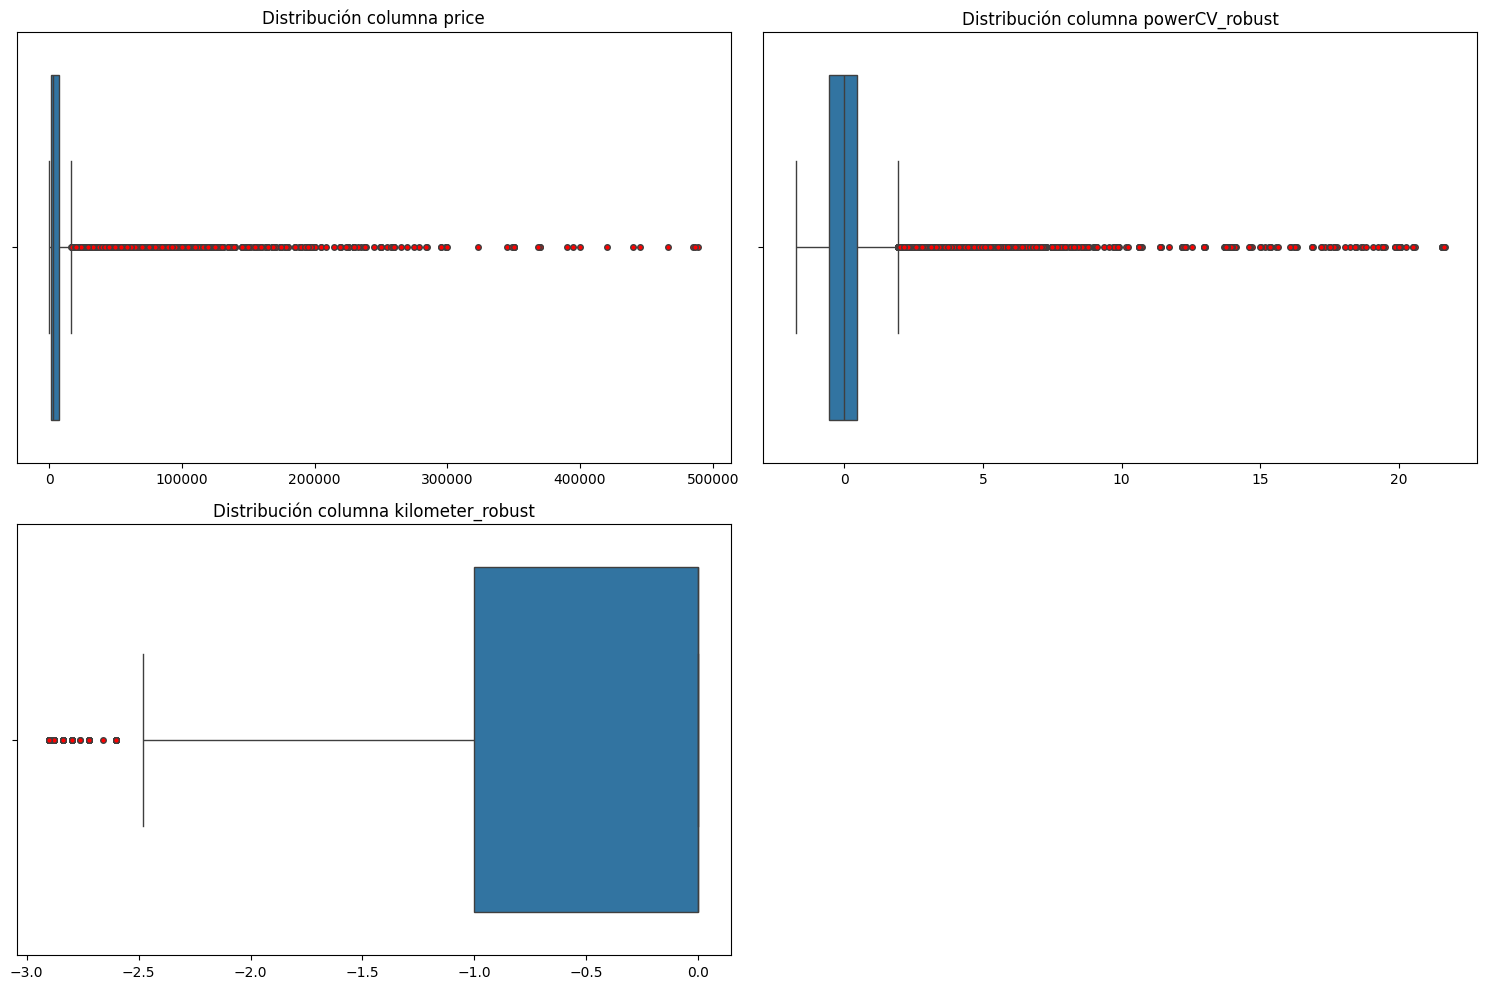

In [57]:
f.plot_outliers_univariados(df_filt, "b", (15,10))

In [58]:
df_robust_con3=df_robust[["price", "powerCV_robust", "kilometer_robust"]]

In [59]:
(df_filt["kilometer_robust"]< -2.5).sum()

np.int64(13478)

In [60]:
(df_robust_con3["kilometer_robust"]< -2.5).sum()

np.int64(13419)

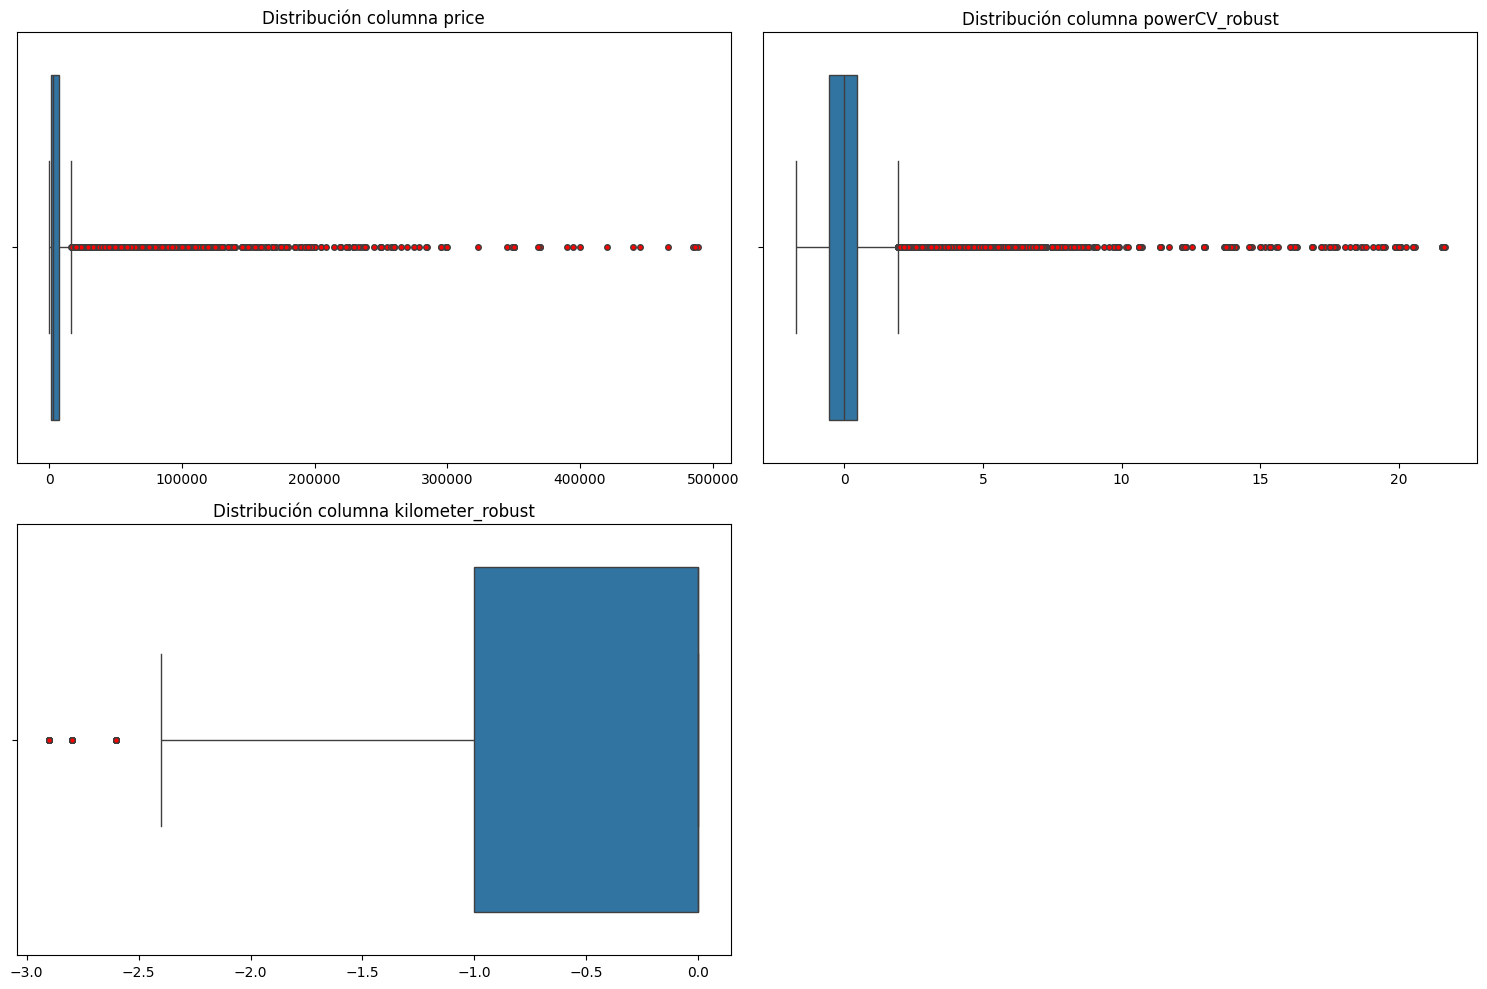

In [61]:
f.plot_outliers_univariados(df_robust_con3, "b", (15,10))

caso con iterative

In [62]:
df_numericas=df_result.select_dtypes(include=np.number)
df_numericas.drop(columns="price", inplace=True)
imputer_iterative= IterativeImputer()       #Aquí se puede poner el KNNImputer o el RandomForestRegressor
                                            #missing values es por si los nulos no estan como np.nan sino en texto por ejemplo (aunque lo suyo es limpiarlo en el EDA)
                                            #initial_strategy= "median" sirve para indicar que me lo haga con las medianas
iterative_imputado=imputer_iterative.fit_transform(df_numericas)   #como es solo para numericas se tiene que meter el df de numericas pero hay que definirlo otra vez porque hemos dropeado duplicados
df_iterativo=df_result.copy()
df_num_sin_nulos=pd.DataFrame(iterative_imputado, columns= df_numericas.columns)  #para que tenga los mismo nombres de columnas
df_iterativo[df_numericas.columns]= df_num_sin_nulos    #Con esto metemos todo el dataframe de las numericas sin nulos donde corresponda rellenando esos nulos

In [63]:
df_iterativo.isna().sum()

dateCrawled             0
seller                  0
offerType               0
price                   0
abtest                  0
vehicleType             0
yearOfRegistration      0
gearbox                 0
model                   0
monthOfRegistration     0
fuelType                0
brand                   0
notRepairedDamage       0
lastSeen                0
yearCreated             0
monthCreated            0
powerCV_robust          0
kilometer_robust        0
outliers_lof_0.01_20    0
outliers_lof_0.01_50    0
outliers_lof_0.05_20    0
outliers_lof_0.05_50    0
outliers_lof_0.1_20     0
outliers_lof_0.1_50     0
outliers_lof_0.01_8     0
outliers_lof_0.05_8     0
outliers_lof_0.1_8      0
dtype: int64

In [64]:
df_iterativo.describe().T

count         mean          std       min  \
price                 360401.0  5916.891218  9222.529472  1.000000   
powerCV_robust        360401.0     0.075036     0.976476 -1.746032   
kilometer_robust      360401.0    -0.487443     0.796948 -2.900000   
outliers_lof_0.01_20  360401.0     0.981337     0.192294 -1.000000   
outliers_lof_0.01_50  360401.0     0.981360     0.192180 -1.000000   
outliers_lof_0.05_20  360401.0     0.901360     0.433071 -1.000000   
outliers_lof_0.05_50  360401.0     0.901382     0.433025 -1.000000   
outliers_lof_0.1_20   360401.0     0.801210     0.598384 -1.000000   
outliers_lof_0.1_50   360401.0     0.801210     0.598384 -1.000000   
outliers_lof_0.01_8   360401.0     0.981354     0.192209 -1.000000   
outliers_lof_0.05_8   360401.0     0.901315     0.433164 -1.000000   
outliers_lof_0.1_8    360401.0     0.801210     0.598384 -1.000000   

                              25%     50%          75%            max  
price                 1250.000000  3000.0  7490.000000  488997.000000  
powerCV_robust          -0.555556     0.0     0.444444      21.666667  
kilometer_robust        -1.000000     0.0     0.000000       0.408218  
outliers_lof_0.01_20     1.000000     1.0     1.000000       1.000000  
outliers_lof_0.01_50     1.000000     1.0     1.000000       1.000000  
outliers_lof_0.05_20     1.000000     1.0     1.000000       1.000000  
outliers_lof_0.05_50     1.000000     1.0     1.000000       1.000000  
outliers_lof_0.1_20      1.000000     1.0     1.000000       1.000000  
outliers_lof_0.1_50      1.000000     1.0     1.000000       1.000000  
outliers_lof_0.01_8      1.000000     1.0     1.000000       1.000000  
outliers_lof_0.05_8      1.000000     1.0     1.000000       1.000000  
outliers_lof_0.1_8       1.000000     1.0     1.000000       1.000000

In [65]:
df_iterativo.to_csv("datos\datos_sin_outliers_iterativo.csv")

In [66]:
df_it=pd.read_csv("datos\datos_sin_outliers_iterativo.csv", index_col=0)
df_it.reset_index(drop=True, inplace=True)

In [67]:
df_filt_it=df_it[["price", "powerCV_robust", "kilometer_robust"]]

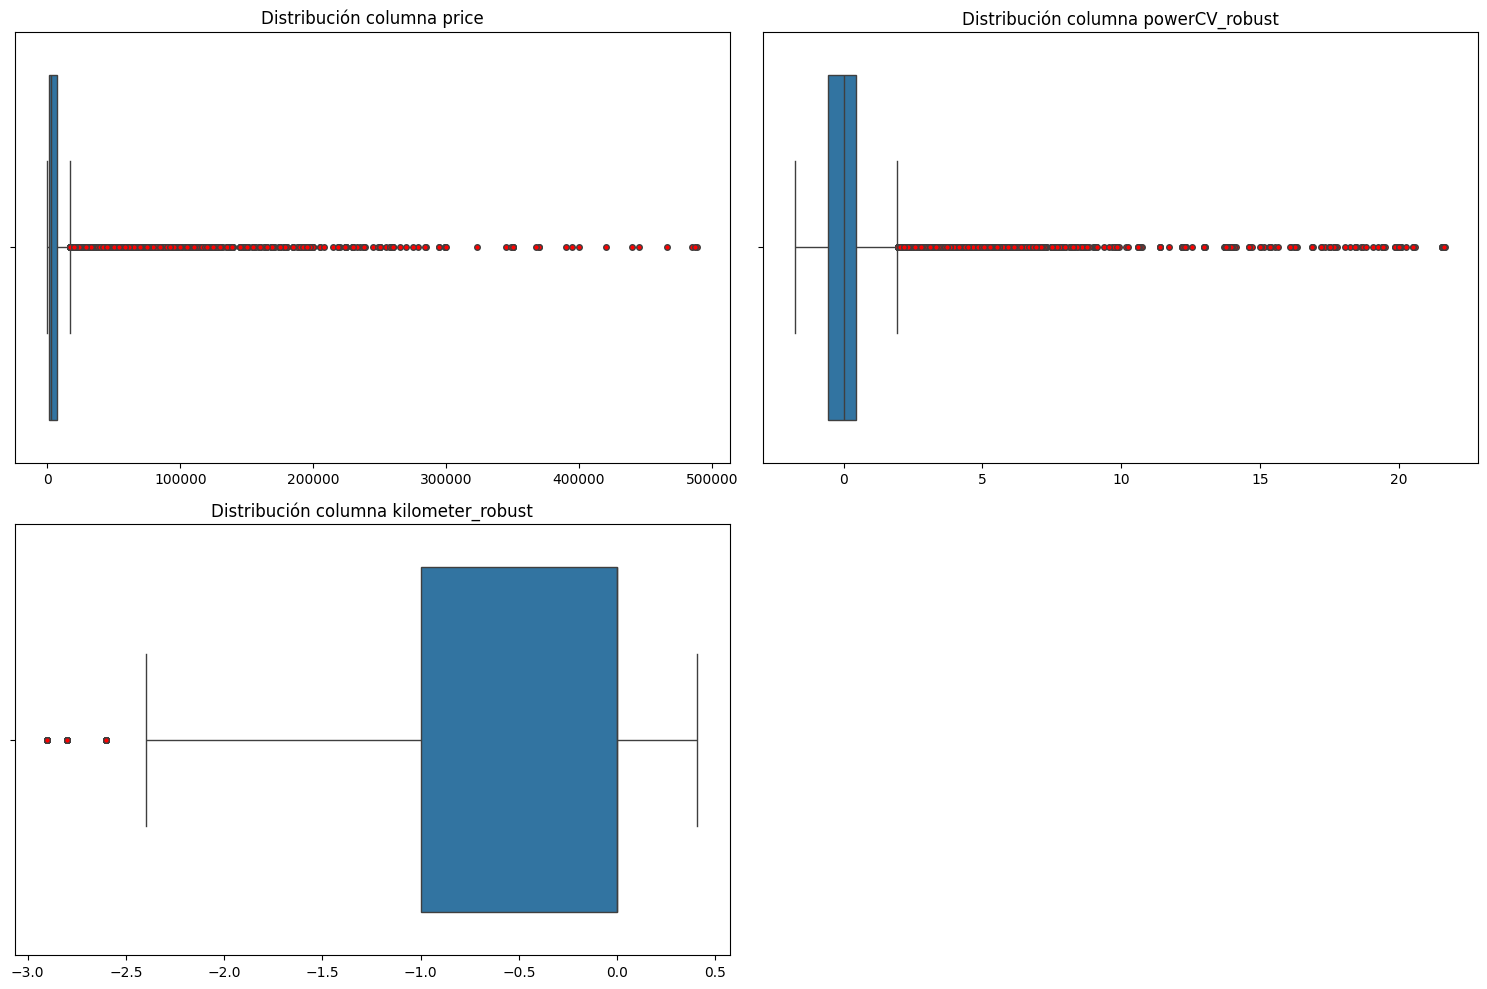

In [68]:
f.plot_outliers_univariados(df_filt_it, "b", (15,10))

In [69]:
df_robust_con3=df_robust[["price", "powerCV_robust", "kilometer_robust"]]

In [70]:
(df_filt_it["kilometer_robust"]< -2.5).sum()

np.int64(13366)

In [71]:
(df_robust_con3["kilometer_robust"]< -2.5).sum()

np.int64(13419)

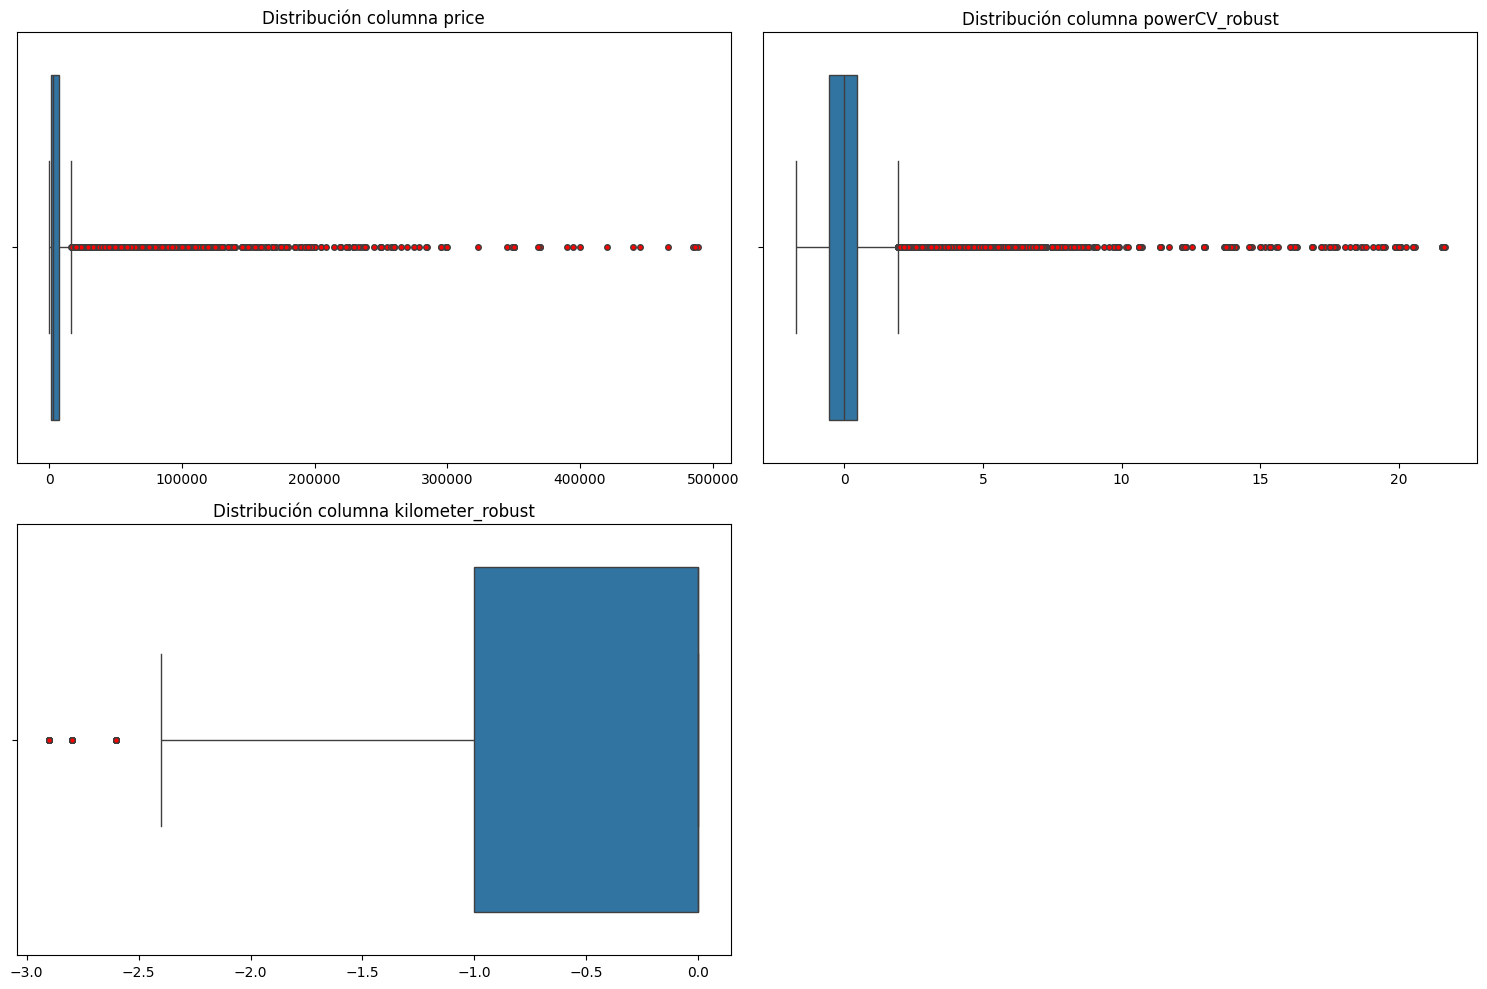

In [72]:
f.plot_outliers_univariados(df_robust_con3, "b", (15,10))

Ya están tratados

Observamos que con KNN nos crea más outliers de los que había originalmente mientras que con el iterative si que se tratan mejor. Por ello finalmente nos quedamos con el iterative